<a href="https://colab.research.google.com/github/AgniKoko/Fetal_ECG_Separation/blob/combined/Fetal_ECG_Separation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fetal ECG Seperation**
## A project for the class of **Electronic Measurements** (DUTH ECE: 8th Semester 2024-2025)

## - Κοκοροτσίκου Αγνή Ιωάννα / Kokorotsikou Agni Ioanna (58767)
## - Ξανθόπουλος Ηλίας / Xanthopoulos Ilias (58545)

## **Part 0**: Set-Up

1) Mount Google drive and load dataset. (Change data_dir to match your dataset directory).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import zipfile

# # ------ Agni's Directory ------
# data_dir = '/content/drive/MyDrive/ColabNotebooks/Fetal_ECG_Separation'
# # ------------------------------

# ------ Ilias' Directory ------
data_dir = '/content/drive/MyDrive/Fetal_ECG_Separation'
# ------------------------------

database_zip = os.path.join(data_dir, 'database-1.0.0.zip')

with zipfile.ZipFile(database_zip, 'r') as zip_ref:
    zip_ref.extractall('/content')

print("Dataset extracted successfully.")

Dataset extracted successfully.


2) Install and import libraries.

In [3]:
!pip install wfdb
!pip install pyedflib
!pip install biosppy
!pip install peakutils
!pip install neurokit2
!pip install PyWavelets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 95.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 61.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyedflib: filename=pyedflib-0.1.40-cp311-cp311-linux_x86_64.whl size=2745166 sha256=13d48689b18f33719abefb5

In [4]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import butter, filtfilt, spectrogram, stft, find_peaks, welch
from scipy.fftpack import fft, fftfreq
from scipy.fft import rfft, rfftfreq, irfft
from sklearn.decomposition import FastICA
import wfdb
import pywt
import pyedflib
import seaborn as sns
import neurokit2 as nk
from biosppy.signals import ecg

## **Part 1**: Signal Extraction



1) Read .edf file of choice, extract saved signals and print useful data information. Seperate ground truth signal ('Direct_1') from the abdomen signals and save QRS types and timestamps of ground truth.

In [5]:
# Input EDF file name
# ----------------------
rec = 'r01'
# ----------------------

file_path = f'/content/abdominal-and-direct-fetal-ecg-database-1.0.0/{rec}.edf'
edf_file = pyedflib.EdfReader(file_path)

signal_num = edf_file.signals_in_file
signal_labels = edf_file.getSignalLabels()
fs = edf_file.getSampleFrequency(0)  # Fs: Sampling Frequency

signals_list = [edf_file.readSignal(i) for i in range(signal_num)]
signals = np.array(signals_list)

print(f"There are {signal_num} signals/channels in edf file.")
print("Signal Labels:", signal_labels)
print(f"Sampling frequency fs: {fs}Hz")
print("(Num of channels, Num of samples over time) = ", signals.shape)

edf_file._close()

ground_truth = signals[0,:]
abdomen_signals = signals[1:,:]

qrs_annotations = wfdb.rdann(file_path, "qrs")

qrs_peaks = np.array(qrs_annotations.sample)
qrs_symbols = np.array(qrs_annotations.symbol)

There are 5 signals/channels in edf file.
Signal Labels: ['Direct_1', 'Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']
Sampling frequency fs: 1000.0Hz
(Num of channels, Num of samples over time) =  (5, 300000)


2) Plot extracted signals over a specified amount of time. For the ground truth, plot the peaks of QRS complex according to saved timestamps as well.

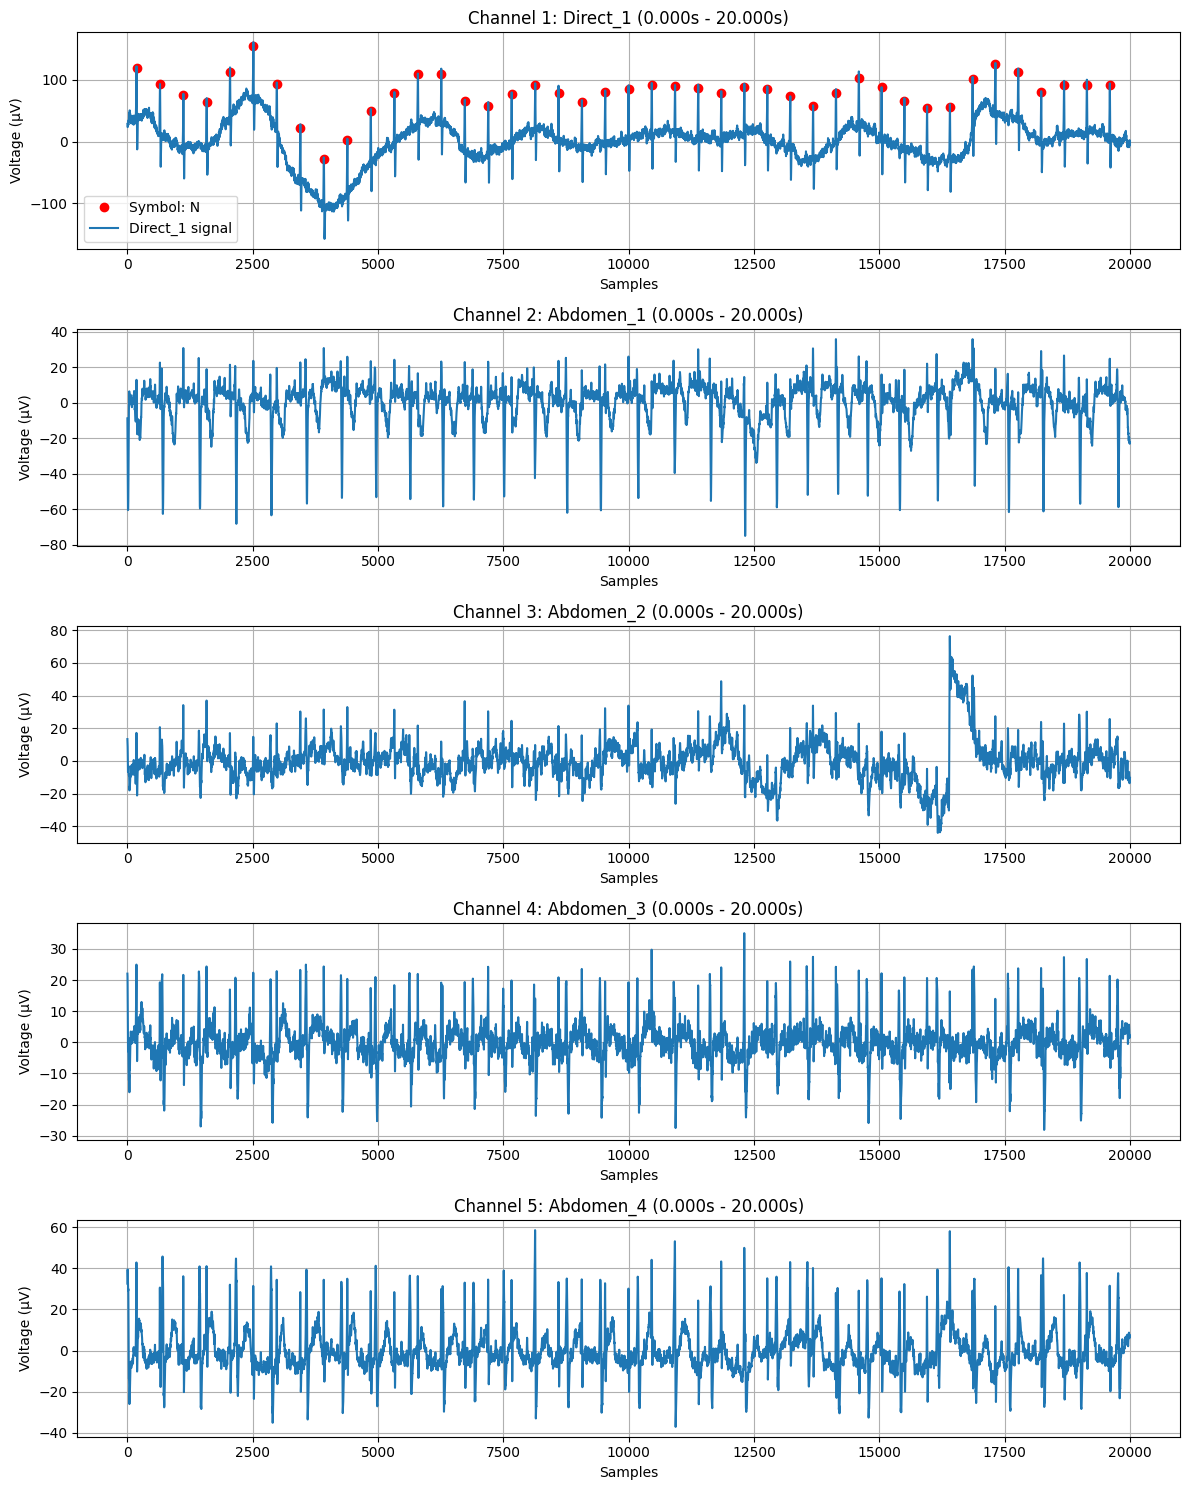

In [11]:
# Input start time and duration (in seconds) for signal plots.
# ----------------------
start_time = 0
duration = 20      # Each signal lasts 300sec.
# ----------------------

# ex. For duration = 300 sec, 300 * fs = 300 * 1000 = 300000 samples.
start_samp = start_time * fs
fin_samp = (start_time + duration) * fs

start_samp = int(np.clip(start_samp, 0, 300 * fs))
fin_samp = int(np.clip(fin_samp, 0, 300 * fs))

symbol_colors = {
    'N': 'r',  # Normal beat - red
    'V': 'g',  # Ventricular - green
    'A': 'yellow',  # Atrial - yellow
    'L': 'orange',  # LBBB - orange
    'R': 'purple',  # RBBB - purple

    '': 'k'   # Unspecified - black
}

cropped_signals = signals[:, start_samp:fin_samp]
cropped_qrs = qrs_peaks[(qrs_peaks >= start_samp) & (qrs_peaks < fin_samp)]
cropped_sym = qrs_symbols[(qrs_peaks >= start_samp) & (qrs_peaks < fin_samp)]
channel_num = cropped_signals.shape[0]

plt.figure(figsize=(12, 3 * channel_num))

for symbol in np.unique(cropped_sym):
    color = symbol_colors.get(symbol, 'gray')  # default to gray if unknown
    sym_samples = cropped_qrs[cropped_sym == symbol] - start_samp
    plt.subplot(channel_num, 1, 1)
    plt.plot(sym_samples, cropped_signals[0,sym_samples], 'o', color=color,
             label=f'Symbol: {symbol}')

plt.plot(cropped_signals[0,:], label='Direct_1 signal')
plt.title(f'Channel {1}: {signal_labels[0]} ({start_time:.3f}s - {start_time + duration:.3f}s)')
plt.xlabel('Samples')
plt.ylabel('Voltage (μV)')
plt.legend()
plt.grid()

for i in range(1, channel_num):
    plt.subplot(channel_num, 1, i + 1)
    plt.plot(cropped_signals[i,:])
    plt.title(f'Channel {i+1}: {signal_labels[i]} ({start_time:.3f}s - {start_time + duration:.3f}s)')
    plt.xlabel('Samples')
    plt.ylabel('Voltage (μV)')
    plt.grid()

plt.tight_layout()
plt.show()

3) Calculate RR Intervals and instantaneous Heart Rate over time. For the instantaneous Heart Rate, plot over a specified time window.

RR Intervals (samples) for first 10 samples: [468 467 465 466 465 468 469 469 469 468]
RR Intervals (seconds) for first 10 samples: [0.468 0.467 0.465 0.466 0.465 0.468 0.469 0.469 0.469 0.468]
Minimum RR Interval (seconds): 0.4

Instantaneous Heart Rates (Hz) for first 10 samples: [2.137 2.141 2.151 2.146 2.151 2.137 2.132 2.132 2.132 2.137]
Instantaneous Heart Rates (bpm) for first 10 samples: [128.205 128.48  129.032 128.755 129.032 128.205 127.932 127.932 127.932
 128.205]
Max instantaneous Heart Rate (Hz): 2.5



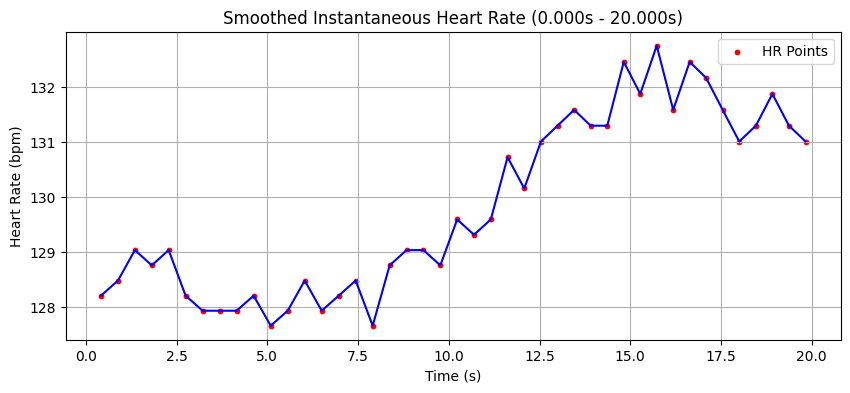

In [7]:
# Input start time and duration (in seconds) for Heart Rate plot.
# ----------------------
start_time = 0
duration = 20      # Signal lasts 300sec.
# ----------------------

end_time = start_time + duration

start_time = np.clip(start_time, 0, 300)
end_time = np.clip(end_time, 0, 300)

rr_intervals = np.diff(qrs_peaks)
print("RR Intervals (samples) for first 10 samples:", rr_intervals[:10])

rr_intervals_sec = rr_intervals / fs
print("RR Intervals (seconds) for first 10 samples:", rr_intervals_sec[:10])

min_rr = np.min(rr_intervals_sec)
print("Minimum RR Interval (seconds):", min_rr)

instantaneous_hr_hz = 1 / rr_intervals_sec
print()
print(f"Instantaneous Heart Rates (Hz) for first 10 samples: {np.round(instantaneous_hr_hz[:10], 3)}")

instantaneous_hr_bpm = instantaneous_hr_hz * 60
print(f"Instantaneous Heart Rates (bpm) for first 10 samples: {np.round(instantaneous_hr_bpm[:10], 3)}")

print("Max instantaneous Heart Rate (Hz):", np.max(instantaneous_hr_hz))

qrs_timestamps = qrs_peaks / fs
hr_timestamps = (qrs_timestamps[:-1] + qrs_timestamps[1:]) / 2

time_mask = (hr_timestamps >= start_time) & (hr_timestamps < end_time)
cropped_hr_times= hr_timestamps[time_mask]
cropped_hr_bpm = instantaneous_hr_bpm[time_mask]

print()
plt.figure(figsize=(10, 4))
plt.plot(cropped_hr_times, cropped_hr_bpm, color='b')
plt.scatter(cropped_hr_times, cropped_hr_bpm, color='r', s=10, label='HR Points')
plt.title(f'Smoothed Instantaneous Heart Rate ({start_time:.3f}s - {end_time:.3f}s)')
plt.xlabel('Time (s)')
plt.ylabel('Heart Rate (bpm)')
plt.grid(True)
plt.legend()
plt.show()

## **Part 2**: Independent Component Analysis (ICA) Application

1) Check if data needs centering and whitening. Print mean value of signals and covariance matrix. Plot a heatmap of covariance matrix for better visualization.

Data needs FastICA whitening if the mean value of each signal is non-zero (meaning that the signals need centering) and/or the covariance matrix is not equal to the identity matrix.

The mean value of each abdomen channel is: [[0.03170482 0.02849677 0.0525478  0.05981291]]
Signals need centering: True

Covariance Matrix:
[[438.771  21.579  -5.835 -52.742]
 [ 21.579 777.039 125.533  68.361]
 [ -5.835 125.533 255.558  74.517]
 [-52.742  68.361  74.517 383.937]]

Deviation from Identity (Frobenius norm): 1031.432
Data needs whitening: True



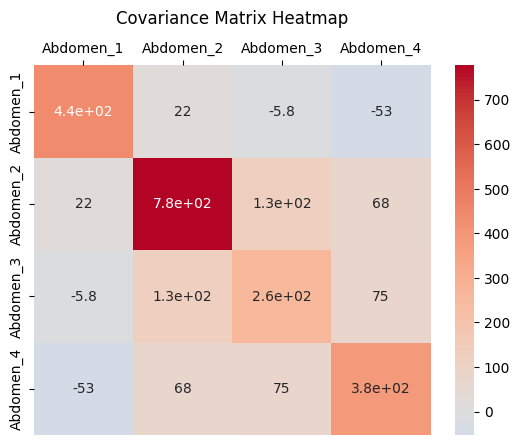

In [8]:
abd_signal_mean = np.mean(abdomen_signals, axis=1, keepdims=True)
center_flag = not np.allclose(abd_signal_mean, np.zeros((abdomen_signals.shape[0],1)),
                                 atol=1e-5)

# Mean array is transposed for clearer reading.
print(f"The mean value of each abdomen channel is:", abd_signal_mean.T)
print("Signals need centering:", center_flag)
print()

cov_mat = np.cov(abdomen_signals)
identity = np.eye(cov_mat.shape[0])
whitening_flag = not np.allclose(cov_mat, identity, atol=1e-5)

# Calculate Frobenius norm for the error. Frobenious norm is defined as the
# square root of the sum of the absolute squares of its elements.
error = np.linalg.norm(cov_mat - identity)

print("Covariance Matrix:")
print(np.round(cov_mat,3))
print()

print(f"Deviation from Identity (Frobenius norm): {error:.3f}")
print("Data needs whitening:", whitening_flag)
print()

cov_heat = sns.heatmap(cov_mat, annot=True, cmap='coolwarm',center=0,
            xticklabels=signal_labels[1:], yticklabels=signal_labels[1:])

cov_heat.xaxis.set_ticks_position('top')
cov_heat.xaxis.set_label_position('top')
cov_heat.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
plt.title("Covariance Matrix Heatmap", pad=30)
plt.show()

2) Perform ICA over the abdomen signals using thee FastICA algorithm. Whitening (+ centering) is applied before ICA, if necessary. Print details of ICA input X, output S and demixing matrix W.

In [9]:
if (whitening_flag or center_flag):
   ica = FastICA(n_components=4,         # = n_channels
                whiten='unit-variance',  # more stable for ECG than 'arbitrary‑variance'
                algorithm='deflation',
                tol=1e-5,                # ECG often needs more iterations
                random_state=42,
                )
else:
  ica = FastICA(n_components=4,          # = n_channels
                whiten=False,
                algorithm='deflation',
                tol=1e-5,                # ECG often needs more iterations
                random_state=42,
                )

S = (ica.fit_transform(abdomen_signals.T)).T
W = ica.components_

ica_components = S

print("---------- ICA Application ----------")
print()
print("Input X: ECG abdomen_signals")
print("Shape: (Num of channels, Num of samples over time) = ", abdomen_signals.shape)
print()
print("Output S: ica_components")
print("Shape: (Num of Components, Num of values over time) = ", ica_components.shape)
print()
print("Demixing Matrix W:\n", W)
print("Shape: (Num of Components, Num of channels) =", W.shape)
print()

---------- ICA Application ----------

Input X: ECG abdomen_signals
Shape: (Num of channels, Num of samples over time) =  (4, 300000)

Output S: ica_components
Shape: (Num of Components, Num of values over time) =  (4, 300000)

Demixing Matrix W:
 [[ 0.0181612  -0.01209934 -0.04755245  0.02940476]
 [-0.00645171  0.03446807 -0.04057267  0.00309487]
 [ 0.0378021   0.00503307  0.00187875 -0.02620004]
 [-0.02288383 -0.00688392 -0.02326201 -0.03548914]]
Shape: (Num of Components, Num of channels) = (4, 4)



3) Plot the components/sources S over time.

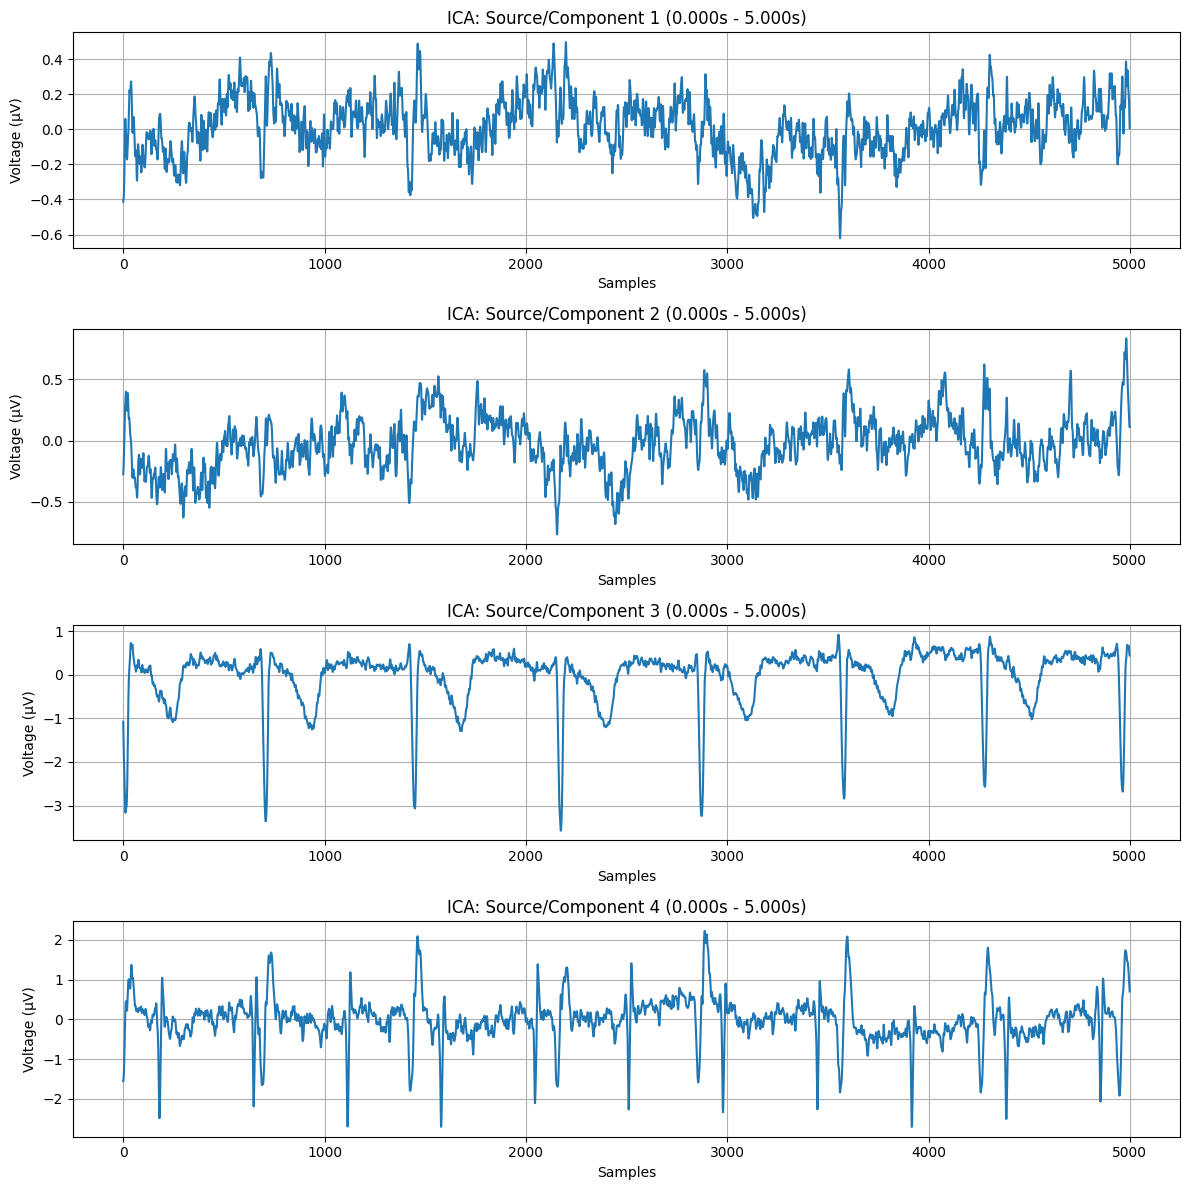

In [12]:
# Input start time and duration (in seconds) for signal plots.
# ----------------------
start_time = 0
duration = 5      # Each signal lasts 300sec.
# ----------------------

end_time = start_time + duration

start_time = np.clip(start_time, 0, 300)
end_time = np.clip(end_time, 0, 300)

# ex. For duration = 3000 sec, 300 * fs = 300 * 1000 = 300000 samples.
cropped_signals = S[:, int(start_time * fs):int(end_time * fs)]
source_num = cropped_signals.shape[0]
plt.figure(figsize=(12, 3 * source_num))
for i in range(source_num):
    plt.subplot(source_num, 1, i + 1)
    plt.plot(cropped_signals[i,:])
    plt.title(f'ICA: Source/Component {i+1} ({start_time:.3f}s - {end_time:.3f}s)')
    plt.xlabel('Samples')
    plt.ylabel('Voltage (μV)')
    plt.grid()

plt.tight_layout()
plt.show()

## **Part 3**: Classification and evaluation


In this part the distiction between the Maternal and Fetal ECG is executed. The classification is achieved through the calculation of a Similarity index. Different version of the component signals are tested in order to achieve a better Similarity Score and as a result an easier/more relable classificarion

After that the signals are visualized with the use of Wavelets to better understand the distictions between the different Components.

### **Part 3.1**: Classification

1) Calculate a Similarity (to the Ground Truth) index for all components based on three metrics:

*   Deviation from average Fetal HR.
*   Cross-correlation with Fetal truth.
*   Matches with Ground Turh R-peaks.

For each component, calculate the three metrics and add them with different weights for the final Similarity Index. Plot the corresponding graphs.



---------- Component 1 ----------
  - Mean HR: 102.8 bpm
  - Cross-correlation with fetal truth: 0.000
  - Matches with fetal truth: 70
  - Fetal likelihood score: 0.054



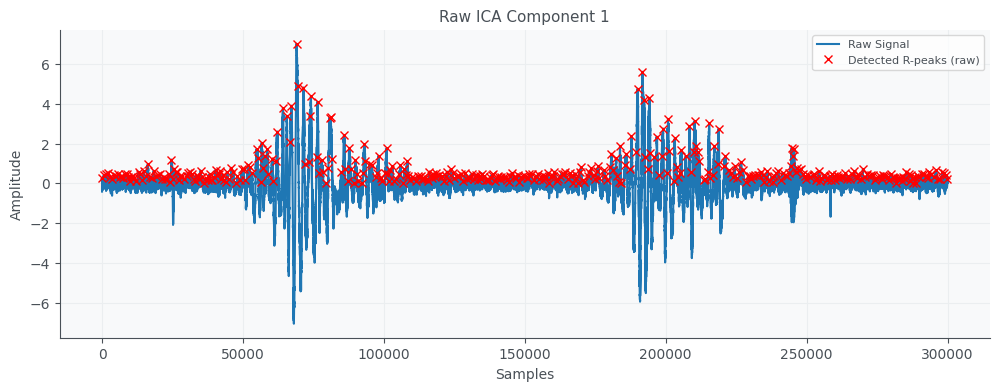

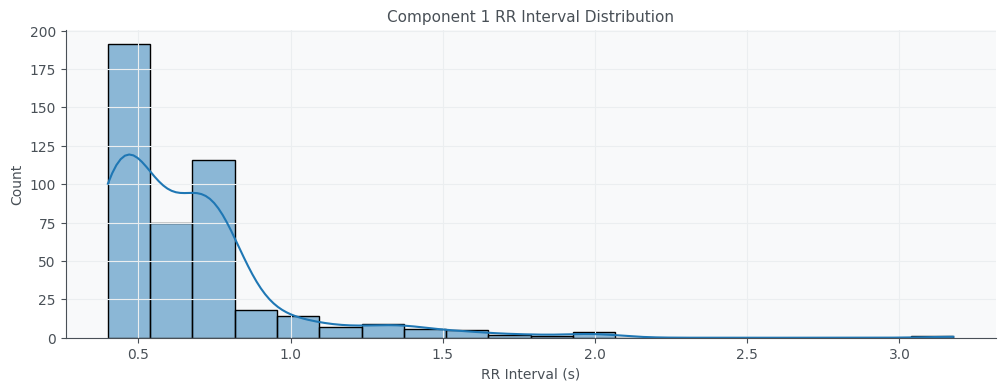

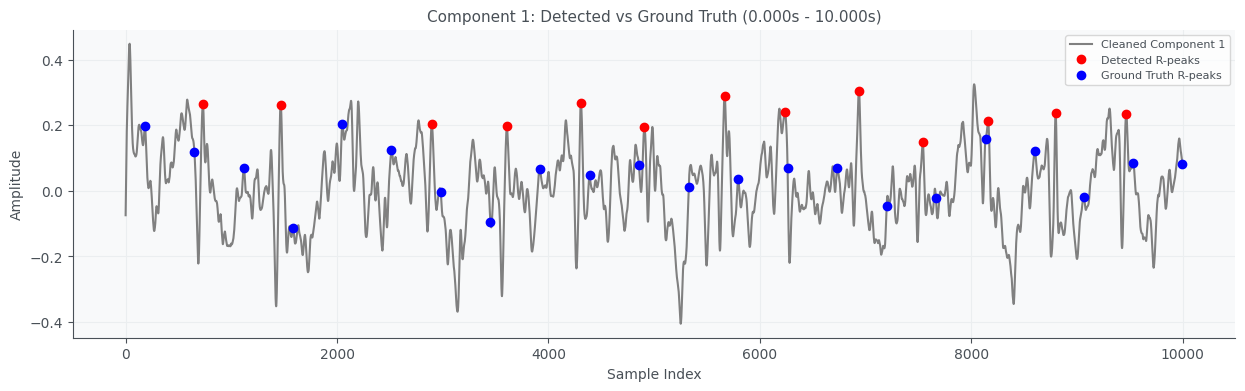

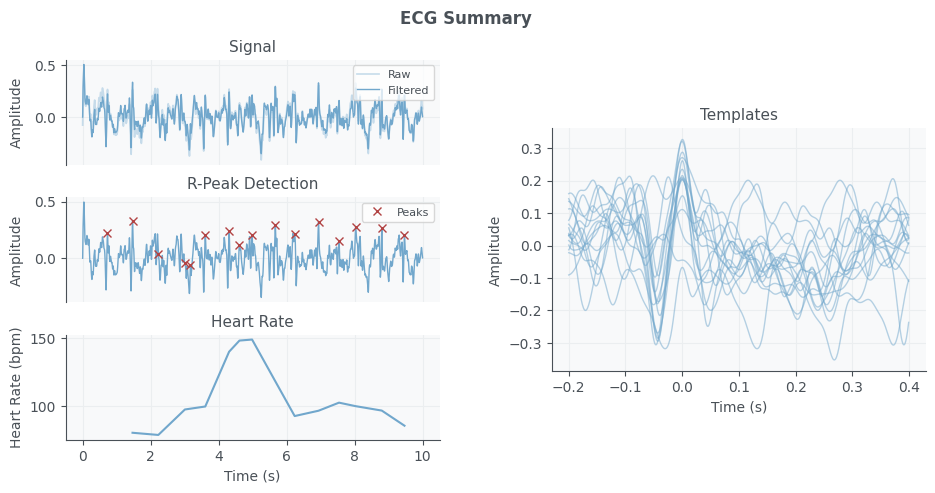



---------- Component 2 ----------
  - Mean HR: 110.1 bpm
  - Cross-correlation with fetal truth: 0.002
  - Matches with fetal truth: 64
  - Fetal likelihood score: 0.106



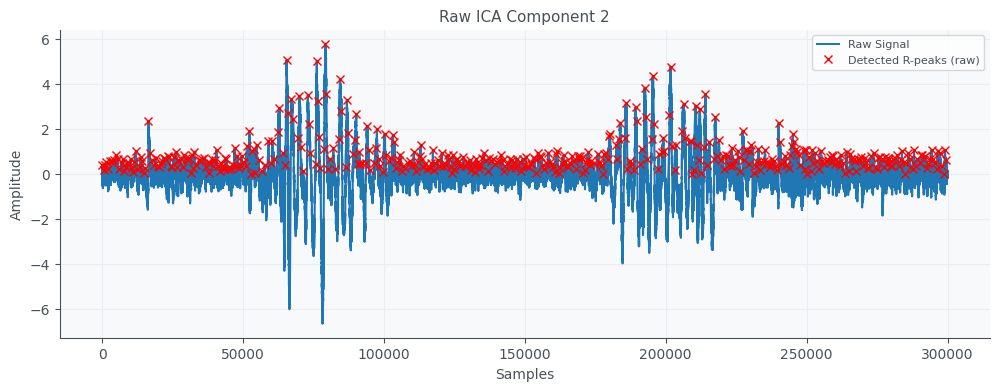

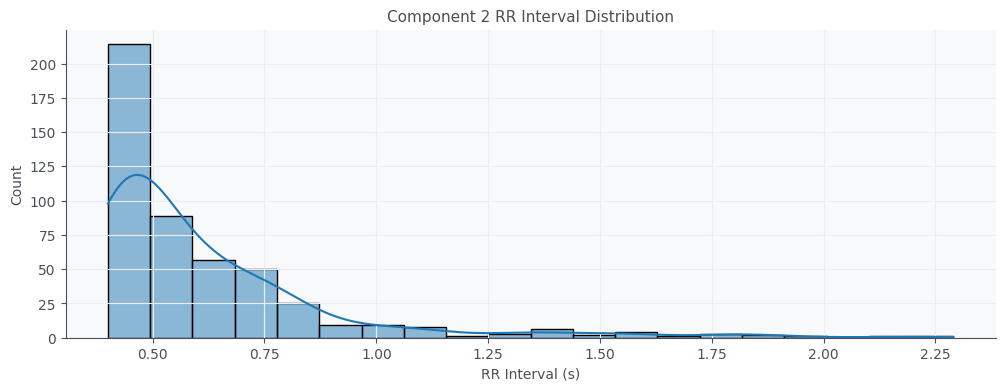

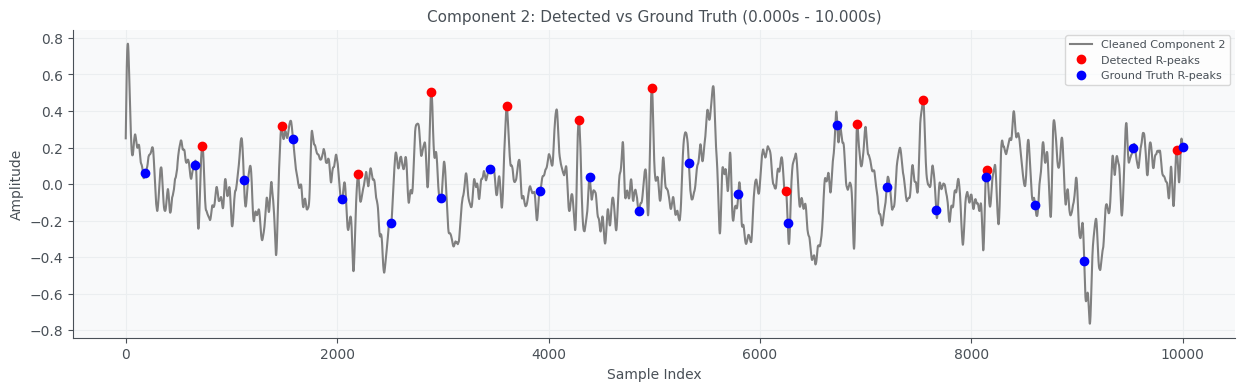

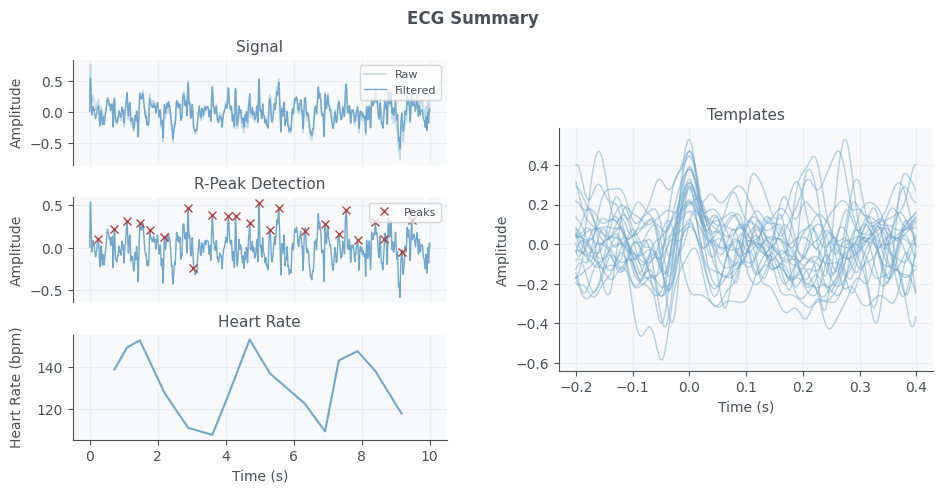



---------- Component 3 ----------
  - Mean HR: 106.8 bpm
  - Cross-correlation with fetal truth: -0.011
  - Matches with fetal truth: 85
  - Fetal likelihood score: 0.086



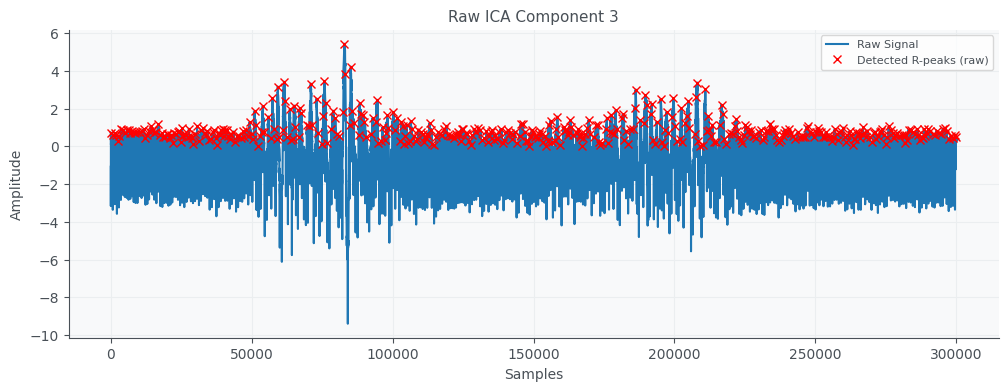

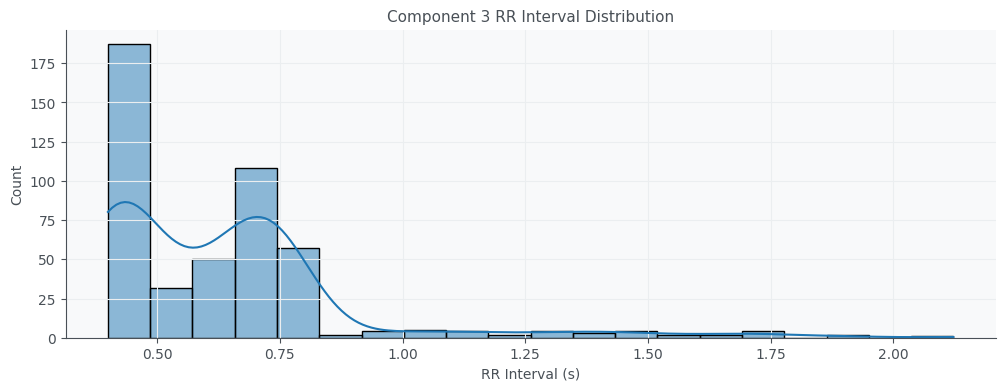

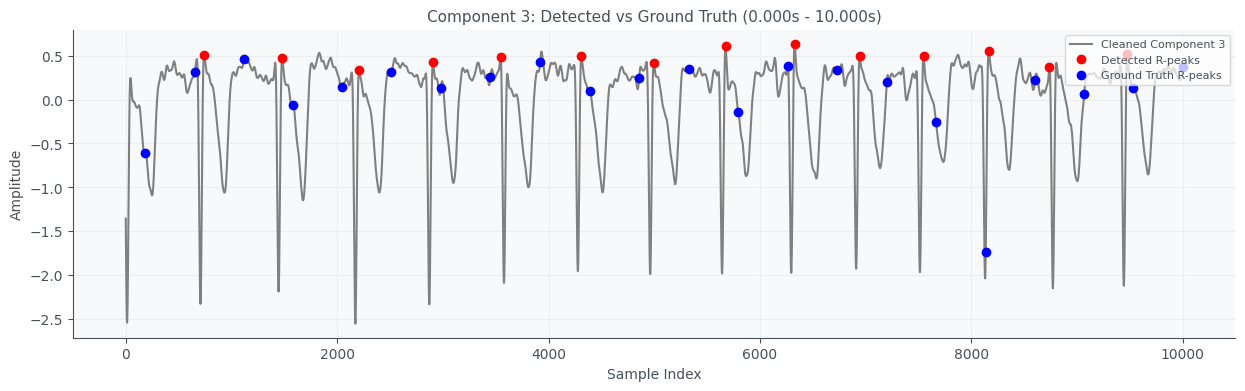

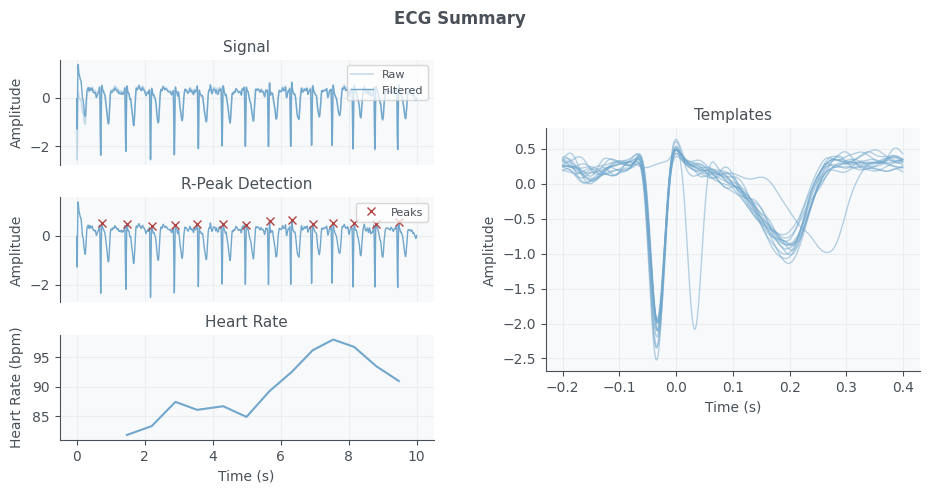



---------- Component 4 ----------
  - Mean HR: 99.0 bpm
  - Cross-correlation with fetal truth: 0.334
  - Matches with fetal truth: 315
  - Fetal likelihood score: 0.280



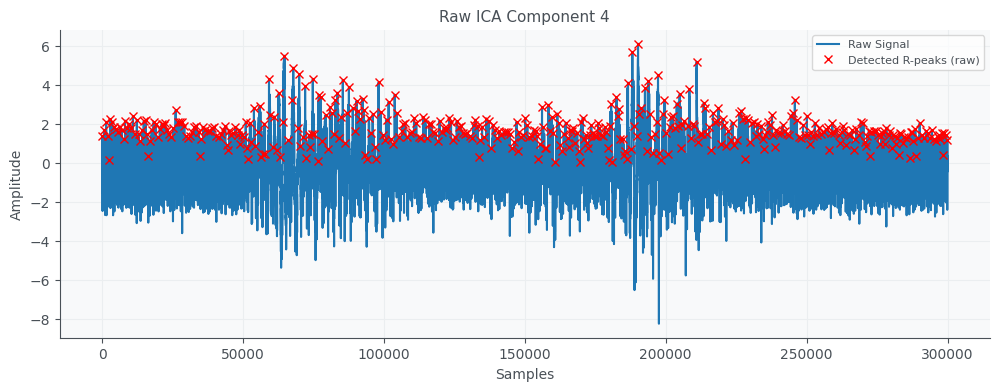

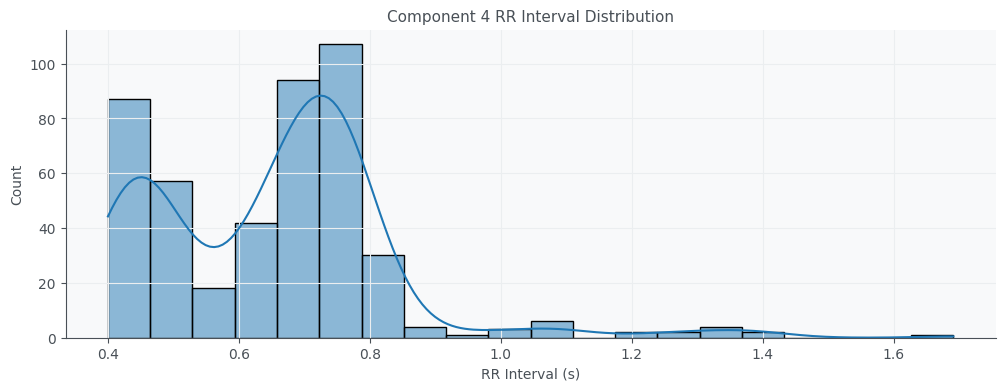

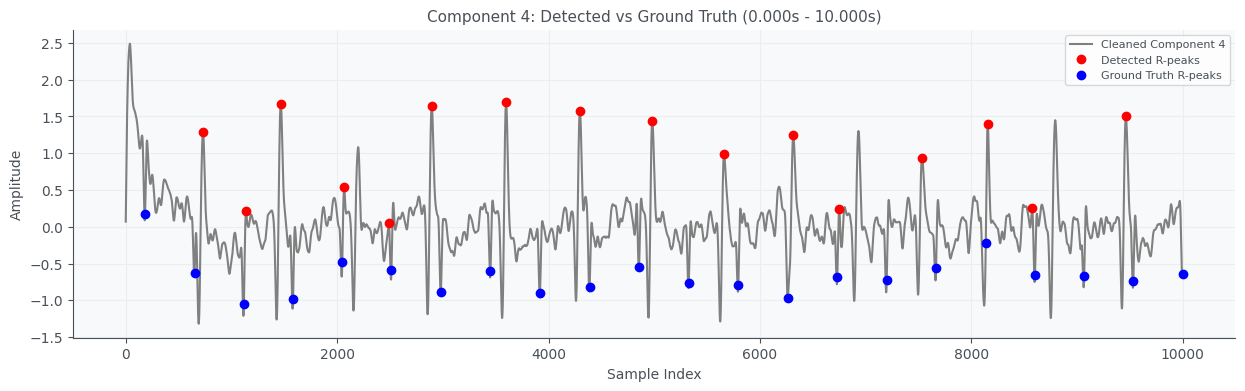

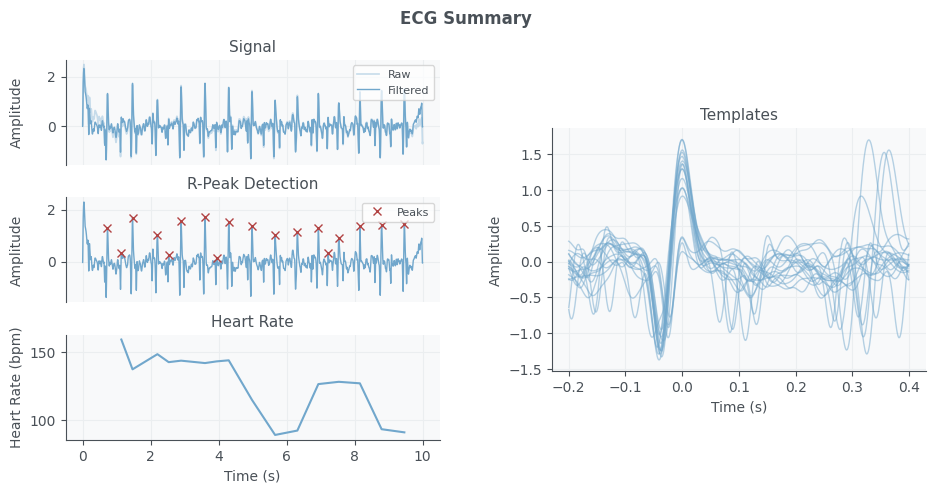

In [14]:
# Input start time and duration (in seconds) for signal plots.
# Input the tolerance for R-peaks deviation.
# ----------------------
start_time = 0
segment_duration = 10      # Each signal lasts 300sec.

tolerance = 50          # ±samples to count match
# ----------------------

end_time = start_time + segment_duration

# ex. For segment_duration = 300 sec, 300 * fs = 300 * 1000 = 300000 samples.
start_samp = start_time * fs
fin_samp = (start_time + segment_duration) * fs

start_samp = int(np.clip(start_samp, 0, 300 * fs))
fin_samp = int(np.clip(fin_samp, 0, 300 * fs))


# ---------- Helper Functions ----------

def estimate_rr_hr(ecg_signal, fs):

    peaks, _ = find_peaks(ecg_signal, distance=fs * 0.4, height=np.mean(ecg_signal))
    rr_intervals = np.diff(peaks) / fs
    heart_rates = 60 / rr_intervals if len(rr_intervals) else np.array([])

    return peaks, rr_intervals, heart_rates


def dominant_frequency(signal, fs):

    f, Pxx = welch(signal, fs, nperseg=int(fs * 4))
    dominant_freq = f[np.argmax(Pxx)]

    return dominant_freq


def count_matches(detected_peaks, reference_peaks, tolerance=tolerance):

    matches = 0
    for peak in detected_peaks:
        if np.any(np.abs(reference_peaks - peak) <= tolerance):
            matches += 1

    return matches


def cross_correlation_score(detected_peaks, reference_peaks, length, tolerance=tolerance):
    """Cross-correlation between binary peak trains."""

    ref_binary = np.zeros(length)
    det_binary = np.zeros(length)
    ref_binary[np.clip(reference_peaks, 0, length - 1)] = 1
    det_binary[np.clip(detected_peaks, 0, length - 1)] = 1

    # Smooth with tolerance
    ref_smooth = np.convolve(ref_binary, np.ones(tolerance*2 + 1), mode='same')
    det_smooth = np.convolve(det_binary, np.ones(tolerance*2 + 1), mode='same')
    correlation = np.corrcoef(ref_smooth, det_smooth)[0, 1]

    return correlation


def compute_fetal_likelihood(correlation, match_count, mean_hr, total_possible_matches):

    norm_corr = correlation  # assume it's already between 0–1
    norm_match = match_count / total_possible_matches if total_possible_matches else 0
    hr_score = 1 - abs(mean_hr - 140) / 40 if 100 <= mean_hr <= 180 else 0  # normalize around fetal HR

    # Weighted score (can adjust weights as needed)
    return (0.4 * norm_corr) + (0.3 * norm_match) + (0.3 * hr_score)


def analyze_ica_components(ica_components, fs, qrs_peaks):

    n_components = ica_components.shape[0]

    for i in range(n_components):

        print(f"\n\n---------- Component {i + 1} ----------")

        # Raw component
        raw = ica_components[i, :]
        cleaned = nk.ecg_clean(raw, sampling_rate=fs, method='neurokit')


        # R-peak detection (cleaned)
        _, info = nk.ecg_peaks(cleaned, sampling_rate=fs)
        detected_peaks = info['ECG_R_Peaks']


        # RR + HR (raw)
        peaks, rr, hr = estimate_rr_hr(raw, fs)
        df = dominant_frequency(raw, fs)
        correlation = cross_correlation_score(detected_peaks, qrs_peaks, length=len(cleaned), tolerance=tolerance)

        print(f"  - Mean HR: {np.mean(hr):.1f} bpm" if len(hr) else "  - HR: N/A")
        # print(f"  - Dominant Freq: {df:.2f} Hz ({df * 60:.1f} bpm)")
        print(f"  - Cross-correlation with fetal truth: {correlation:.3f}")


        # Ground truth match
        matches = count_matches(detected_peaks, qrs_peaks, tolerance=tolerance)
        print(f"  - Matches with fetal truth: {matches}")

        likelihood = compute_fetal_likelihood(
            correlation,
            matches,
            np.mean(hr) if len(hr) else 0,
            total_possible_matches=len(qrs_peaks)
        )
        print(f"  - Fetal likelihood score: {likelihood:.3f}\n")


        # Plot 1: Raw signal with R-peaks
        plt.figure(figsize=(12, 4))
        plt.plot(raw, label='Raw Signal')
        plt.plot(peaks, raw[peaks], 'rx', label='Detected R-peaks (raw)')
        plt.legend(); plt.title(f'Raw ICA Component {i + 1}')
        plt.xlabel('Samples'); plt.ylabel('Amplitude'); plt.grid(True); plt.show()


        # Plot 2: RR histogram (raw)
        if len(rr):
            plt.figure(figsize=(12, 4))
            sns.histplot(rr, bins=20, kde=True)
            plt.title(f"Component {i + 1} RR Interval Distribution")
            plt.xlabel("RR Interval (s)"); plt.grid(True); plt.show()


        # Plot 3: Cleaned signal + R-peaks + ground truth

        signal = cleaned[start_samp:fin_samp]
        det_in = detected_peaks[(detected_peaks >= start_samp) & (detected_peaks < fin_samp)]
        gt_in = qrs_peaks[(qrs_peaks >= start_samp) & (qrs_peaks < fin_samp)]

        plt.figure(figsize=(15, 4))
        plt.plot(signal, 'gray', label=f'Cleaned Component {i + 1}')
        plt.plot(det_in - start_samp, cleaned[det_in], 'ro', label='Detected R-peaks')
        plt.plot(gt_in - start_samp, cleaned[gt_in], 'bo', label='Ground Truth R-peaks')
        plt.legend(); plt.title(f'Component {i + 1}: Detected vs Ground Truth ({start_time:.3f}s - {end_time:.3f}s)')
        plt.xlabel('Sample Index'); plt.ylabel('Amplitude'); plt.grid(True); plt.show()\

        # Assuming 'signal' is your ECG data and 'fs' is the sampling rate
        out = ecg.ecg(signal=signal, sampling_rate=fs, show=True)

        # Access R-peak indices
        rpeaks = out['rpeaks']

# --------------------------------------


analyze_ica_components(ica_components, fs, qrs_peaks)

2) Filter out for all component signals the frequencies that do not correspond to the QRS complexes frequency band using a bandpass filter.

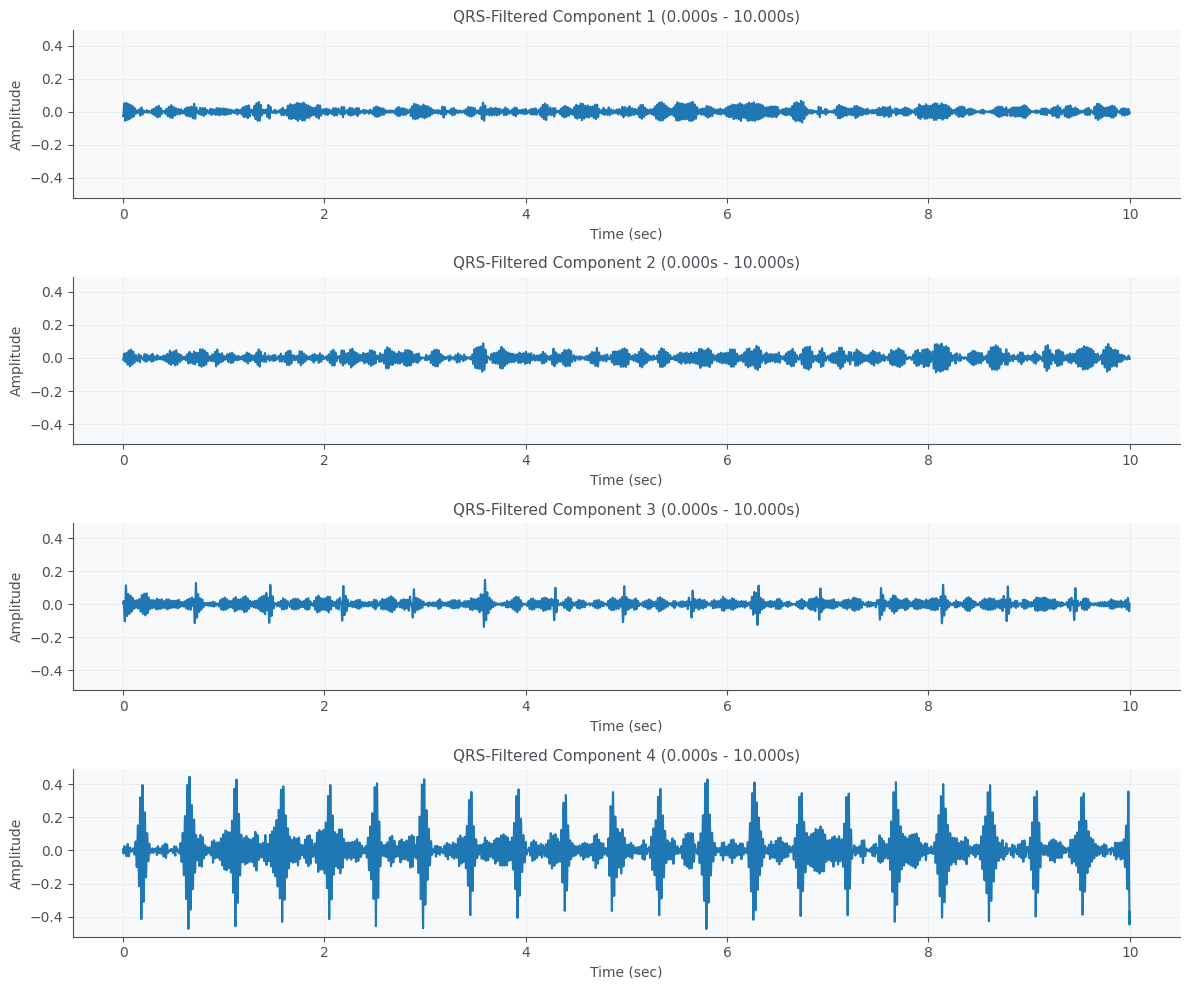

In [15]:
# Input start time and duration (in seconds) for signal plots.
# ----------------------
start_time = 0
segment_duration = 10      # Each signal lasts 300sec.
# ----------------------

end_time = start_time + segment_duration

# ex. For segment_duration = 300 sec, 300 * fs = 300 * 1000 = 300000 samples.
start_samp = start_time * fs
fin_samp = (start_time + segment_duration) * fs

start_samp = int(np.clip(start_samp, 0, 300 * fs))
fin_samp = int(np.clip(fin_samp, 0, 300 * fs))


def bandpass_qrs_filter(data, lowcut, highcut, fs, order=1):

    nyq = 0.5 * fs  # συχνότητα Nyquists
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')

    return filtfilt(b, a, data)


time = np.arange(ica_components.shape[1]) / fs
filtered_qrs_signals = np.zeros_like(ica_components)

for i in range(ica_components.shape[0]):
    filtered_qrs_signals[i, :] = bandpass_qrs_filter(
        data=ica_components[i, :],
        lowcut= 40,
        highcut= 50,
        fs=fs,
    )

fig, axes = plt.subplots(filtered_qrs_signals.shape[0], 1, sharey=True, figsize=(12, 10))
for i, ax in enumerate(axes):
    ax.plot(time[start_samp:fin_samp], filtered_qrs_signals[i, start_samp:fin_samp])
    ax.set_title(f'QRS-Filtered Component {i+1} ({start_time:.3f}s - {end_time:.3f}s)')
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Amplitude')
plt.tight_layout()
plt.show()

3) Recalculate the Similarity index for the filter component signals.



---------- Component 1 ----------
  - Mean HR: 116.4 bpm
  - Cross-correlation with fetal truth: 0.071
  - Matches with fetal truth: 109
  - Fetal likelihood score: 0.202



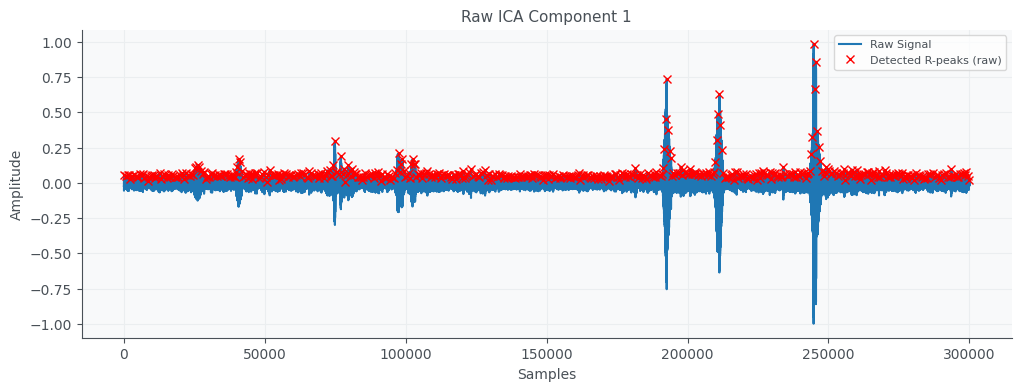

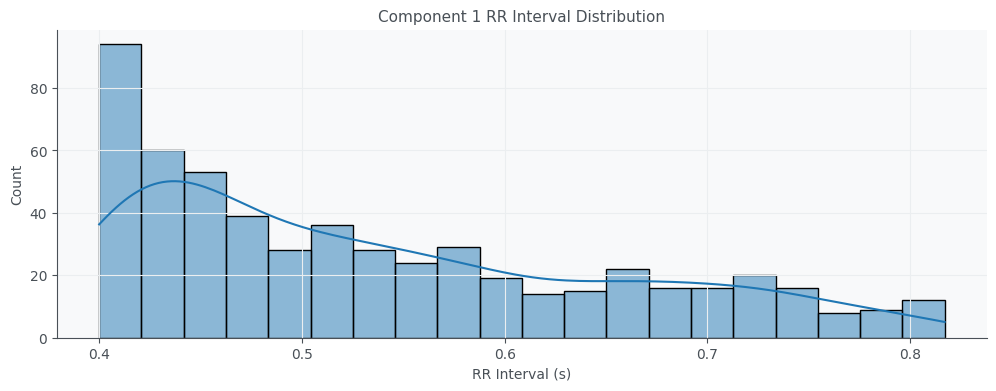

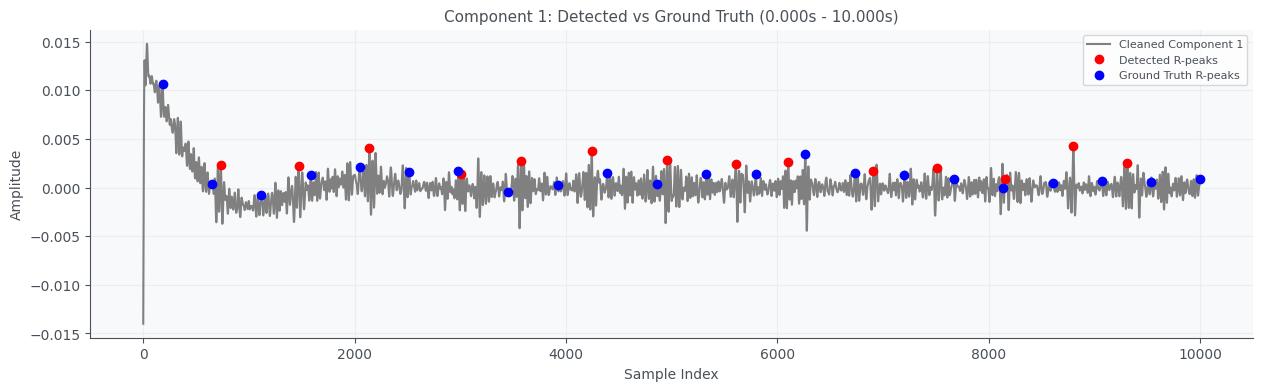

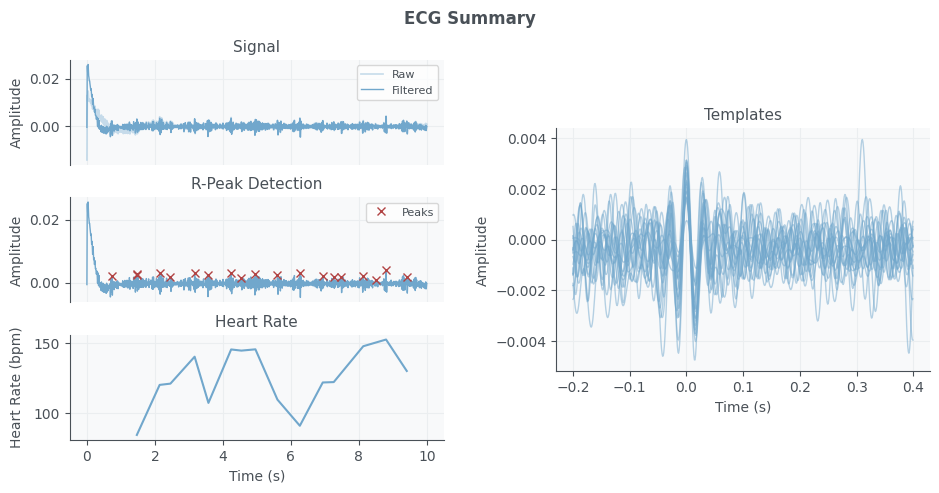



---------- Component 2 ----------
  - Mean HR: 117.6 bpm
  - Cross-correlation with fetal truth: 0.017
  - Matches with fetal truth: 73
  - Fetal likelihood score: 0.173



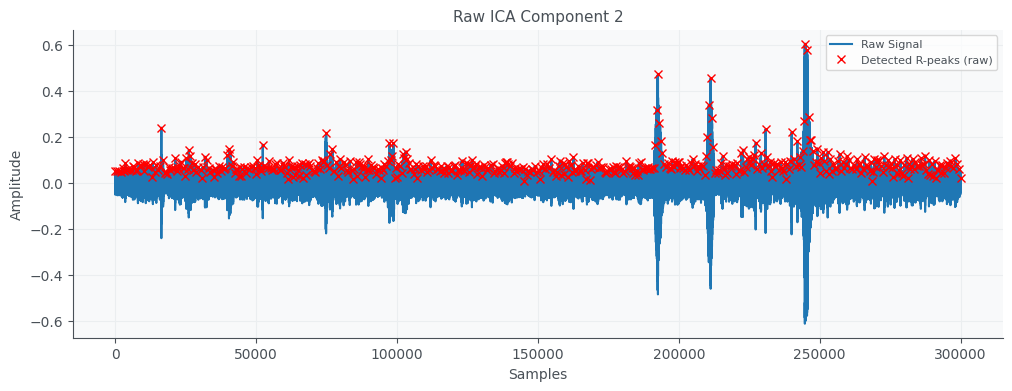

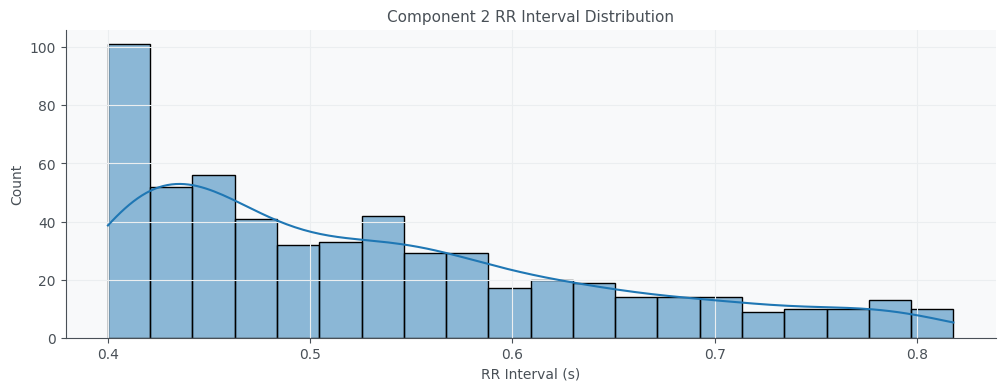

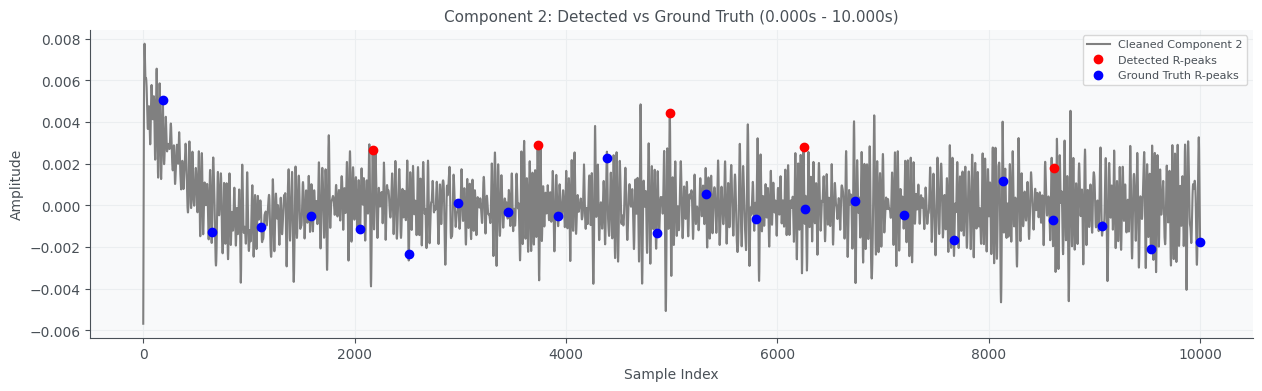

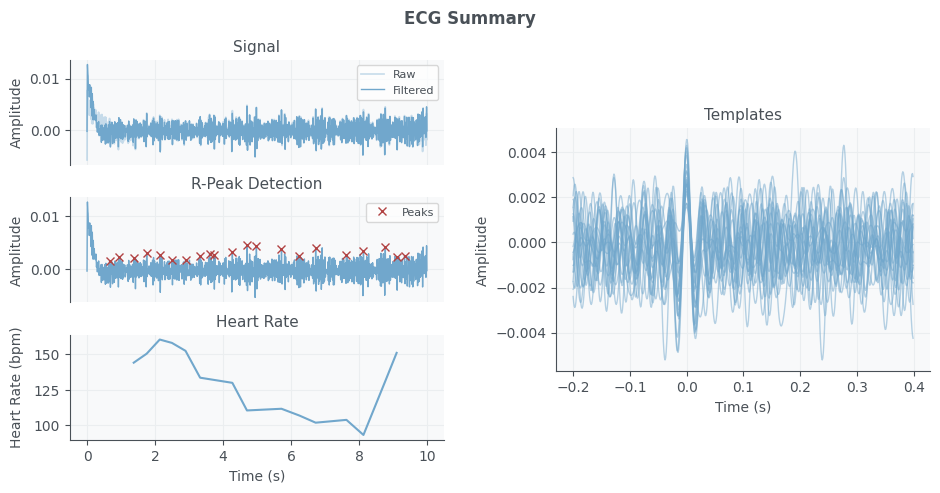



---------- Component 3 ----------
  - Mean HR: 87.9 bpm
  - Cross-correlation with fetal truth: 0.007
  - Matches with fetal truth: 91
  - Fetal likelihood score: 0.045



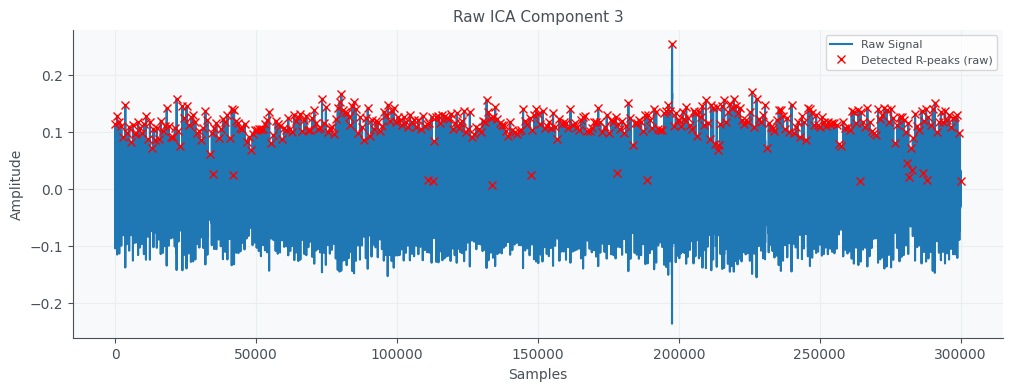

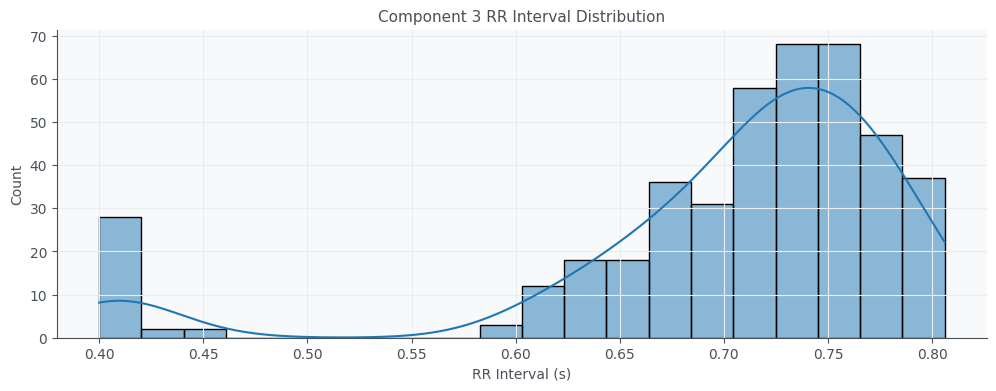

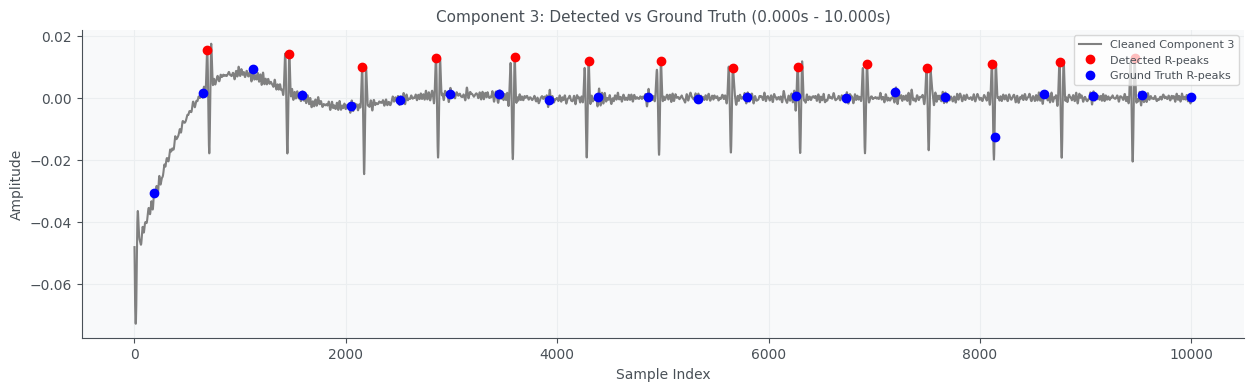

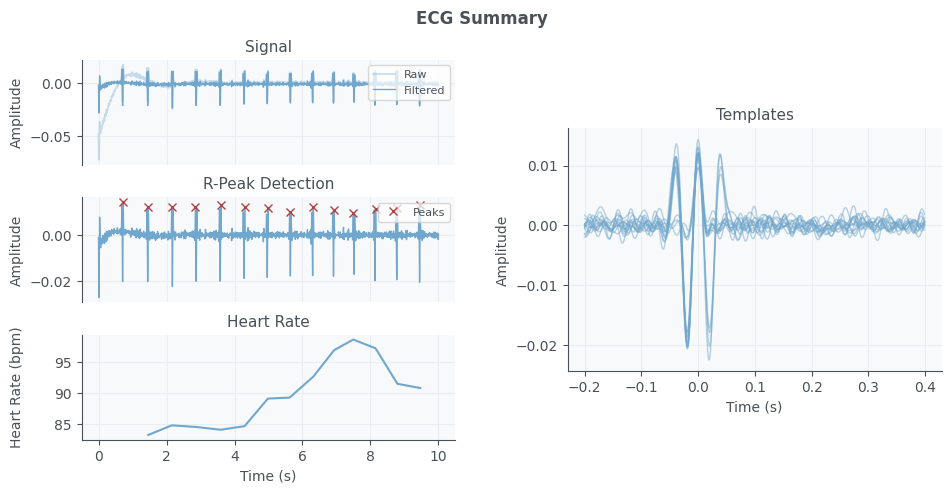



---------- Component 4 ----------
  - Mean HR: 128.6 bpm
  - Cross-correlation with fetal truth: 0.847
  - Matches with fetal truth: 642
  - Fetal likelihood score: 0.852



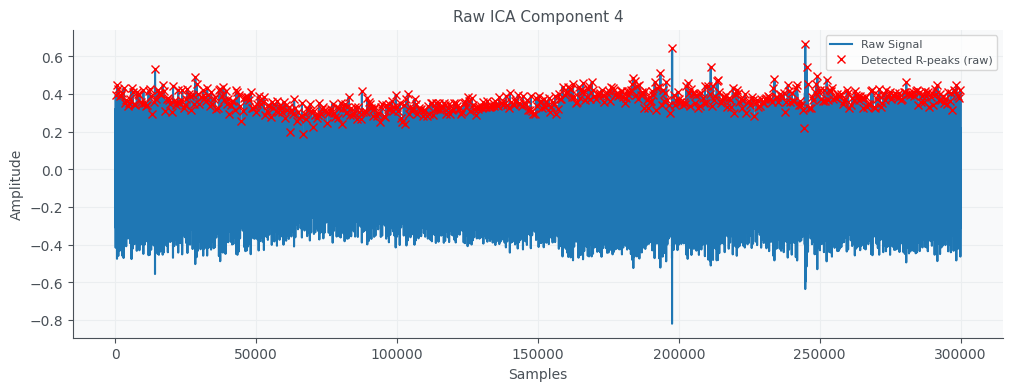

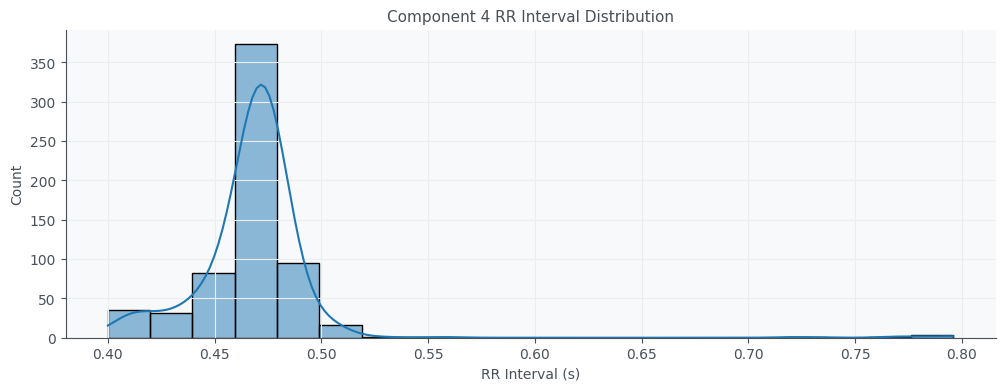

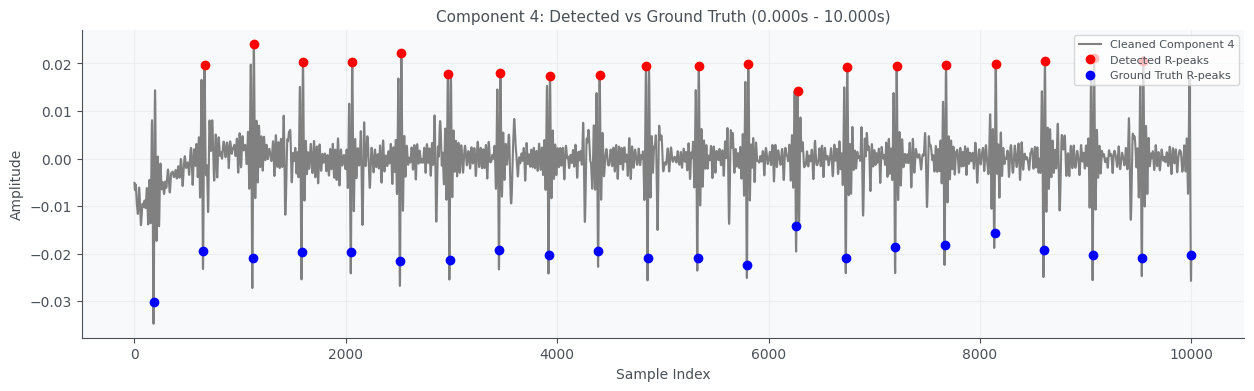

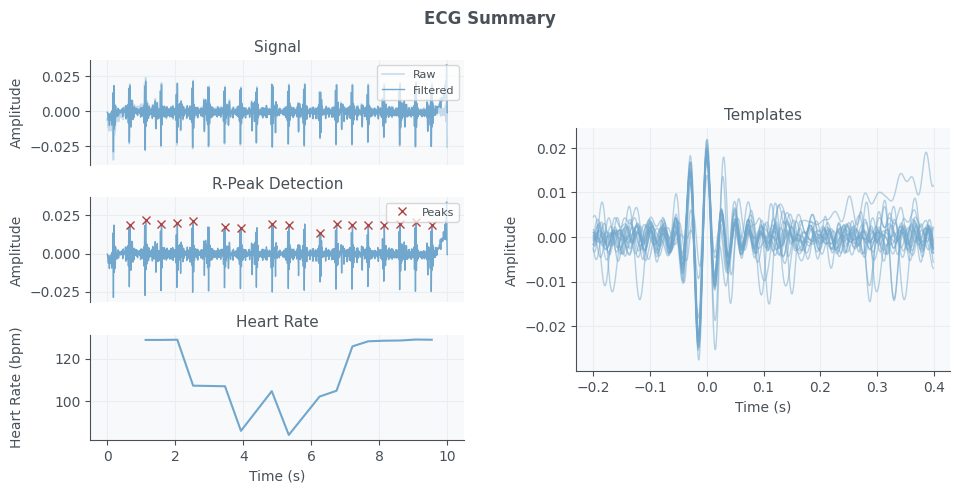

In [16]:
analyze_ica_components(filtered_qrs_signals, fs, qrs_peaks)

### **Part 3.2**: Wavelets

1) Plot the Wavelets of the raw component signals (output of FastICA).

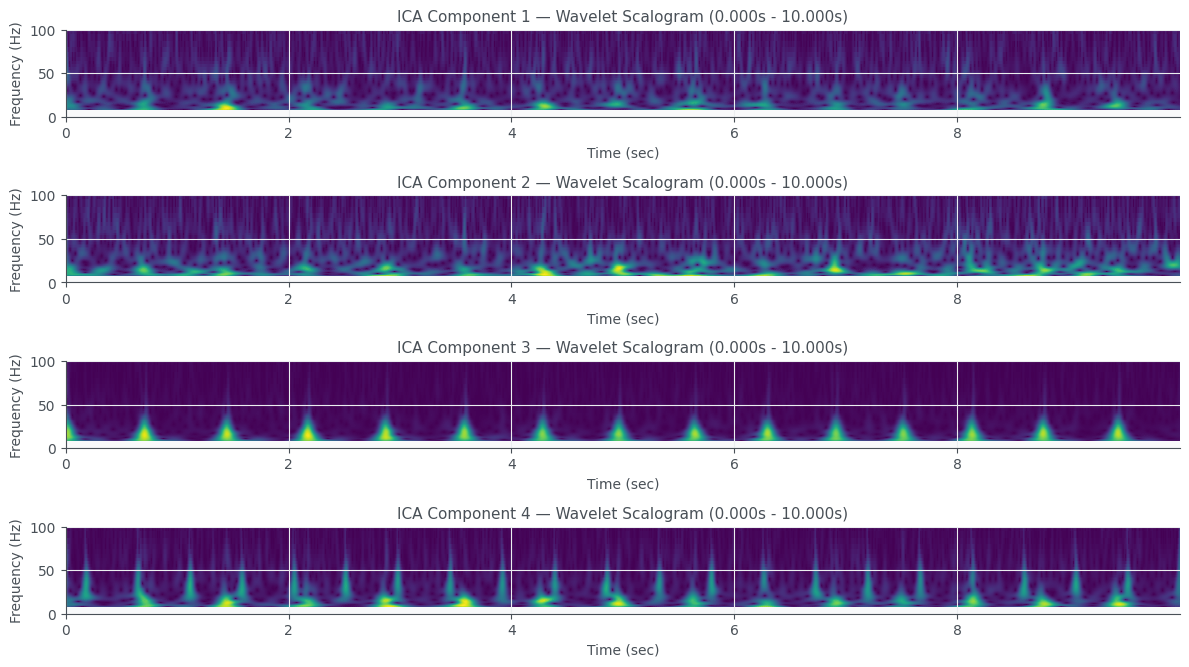

In [17]:
# Input start time and duration (in seconds) for signal plots.
# ----------------------
start_time = 0
segment_duration = 10      # Each signal lasts 300sec.
# ----------------------

end_time = start_time + segment_duration

# ex. For segment_duration = 300 sec, 300 * fs = 300 * 1000 = 300000 samples.
start_samp = start_time * fs
fin_samp = (start_time + segment_duration) * fs

start_samp = int(np.clip(start_samp, 0, 300 * fs))
fin_samp = int(np.clip(fin_samp, 0, 300 * fs))

time = np.arange(ica_components.shape[1]) / fs
time_limit = time[start_samp:fin_samp]


wavelet = 'cmor1.5-1.0'         # complex Morlet
scales = np.arange(1, 128)      # max scale for resolution

plt.figure(figsize=(12, 8))
for i in range(ica_components.shape[0]):
    sig10 = ica_components[i, start_samp:fin_samp]
    coeffs, freqs = pywt.cwt(sig10, scales, wavelet, sampling_period=1/fs)

    plt.subplot(5, 1, i+1)
    plt.pcolormesh(time_limit, freqs, np.abs(coeffs), shading='auto')
    plt.title(f'ICA Component {i+1} — Wavelet Scalogram ({start_time:.3f}s - {end_time:.3f}s)')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (sec)')
    plt.ylim(0, 100)

plt.tight_layout()
plt.show()

2) Plot the Wavelets of the QRS-filtered component signals.

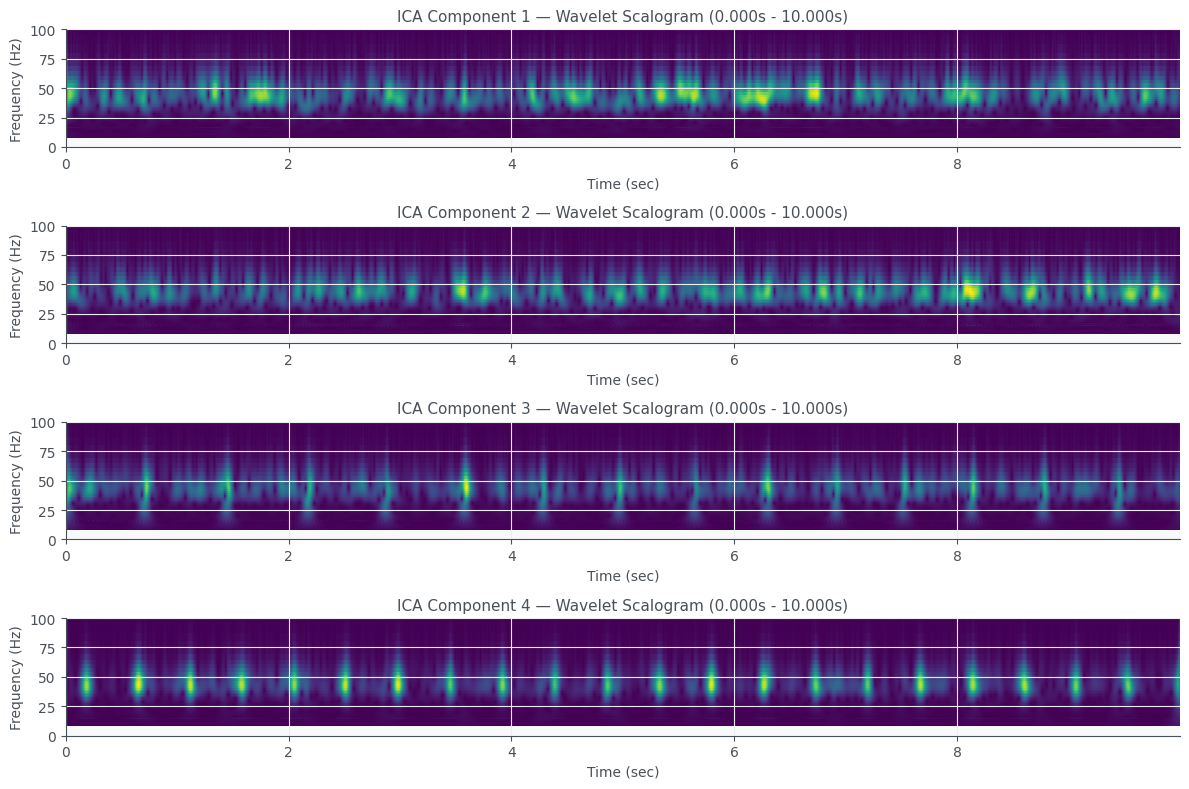

In [18]:
plt.figure(figsize=(12, 8))
for i in range(filtered_qrs_signals.shape[0]):
    sig10 = filtered_qrs_signals[i, start_samp:fin_samp]
    coeffs, freqs = pywt.cwt(sig10, scales, wavelet, sampling_period=1/fs)

    plt.subplot(4, 1, i+1)
    plt.pcolormesh(time_limit, freqs, np.abs(coeffs), shading='auto')
    plt.title(f'ICA Component {i+1} — Wavelet Scalogram ({start_time:.3f}s - {end_time:.3f}s)')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (sec)')
    plt.ylim(0, 100)

plt.tight_layout()
plt.show()

## **Part 4**: Obsolete Methods

Below are methods that have failed but deserve to be mentioned.

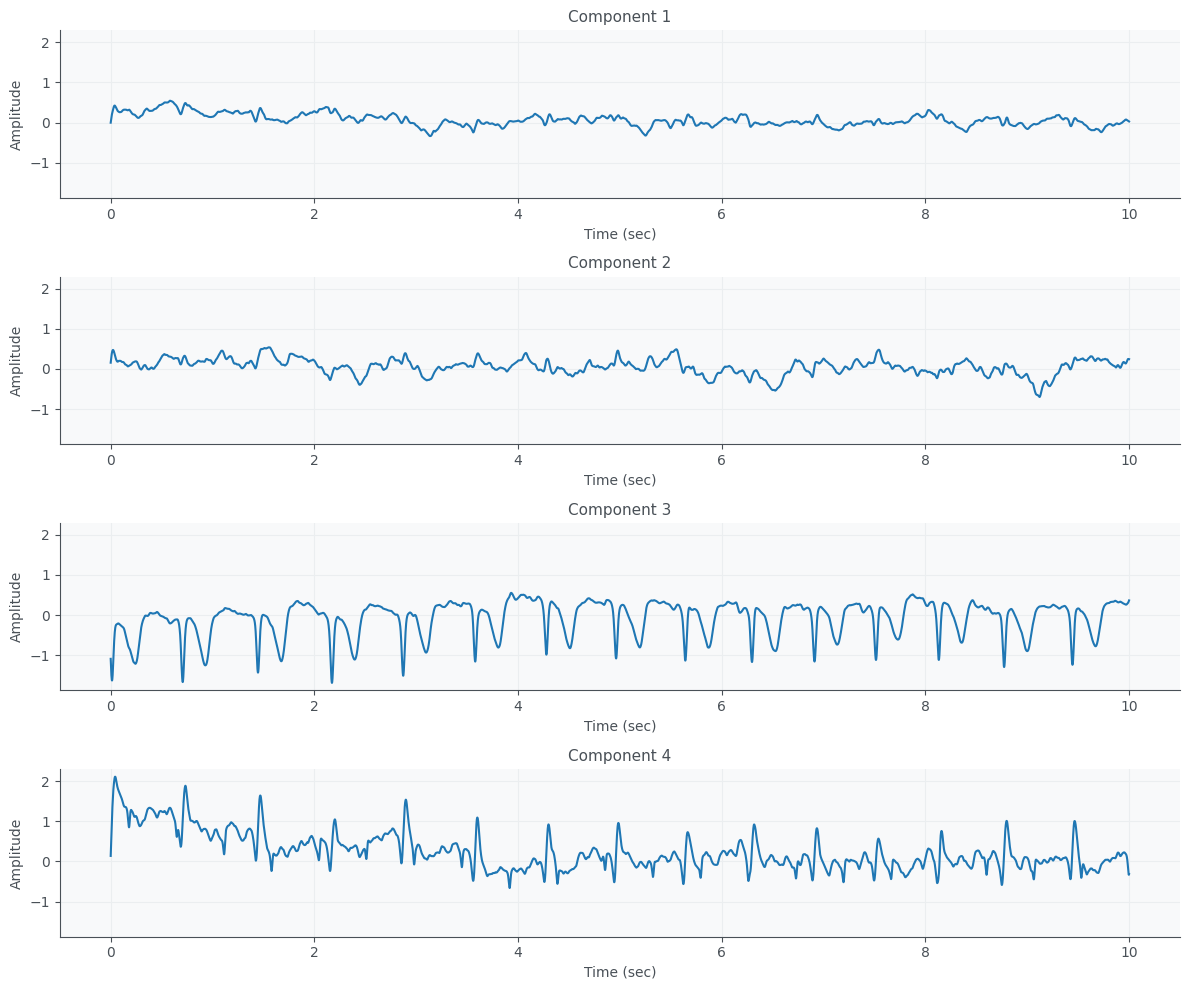

In [18]:
def bandpass_fetal_filter(data, lowcut, highcut, fs, order=1):
    nyq = 0.5 * fs  # συχνότητα Nyquists
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)


time = np.arange(ica_components.shape[1]) / fs
filtered_fetal_signals = np.zeros_like(ica_components)

for i in range(ica_components.shape[0]):
    filtered_fetal_signals[i, :] = bandpass_fetal_filter(
        data=ica_components[i, :],
        lowcut= 0.1,
        highcut= 10,
        fs=fs,
    )

fig, axes = plt.subplots(filtered_fetal_signals.shape[0], 1, sharey=True, figsize=(12, 10))
for i, ax in enumerate(axes):
    ax.plot(time[:10000], filtered_fetal_signals[i, :10000])
    ax.set_title(f'Component {i+1}')
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Amplitude')
plt.tight_layout()
plt.show()

ica_components.shape: (4, 300000)
ica_components[0].shape (first row): (300000,)


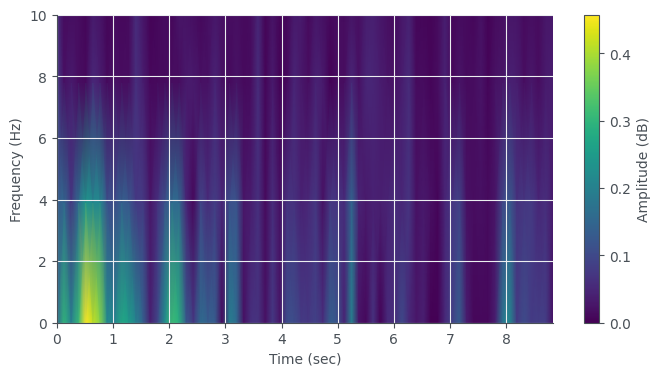

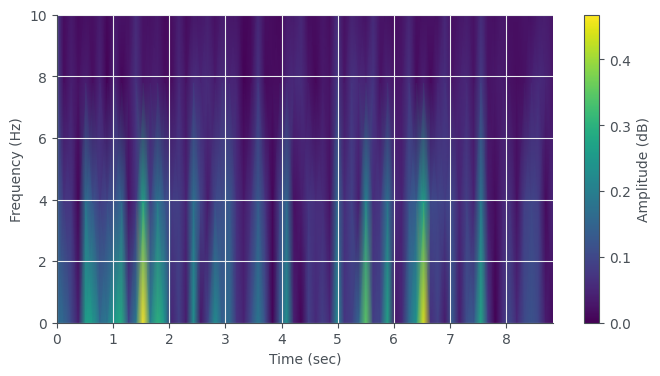

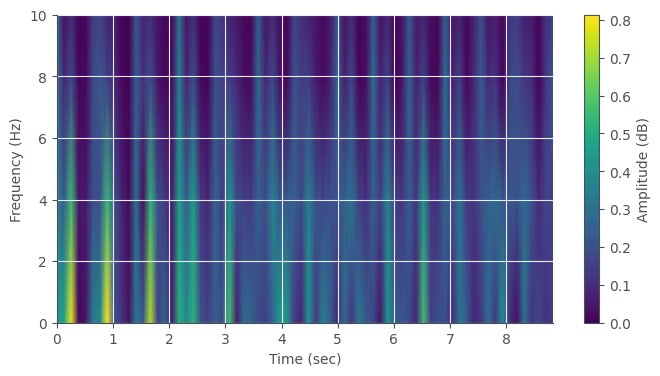

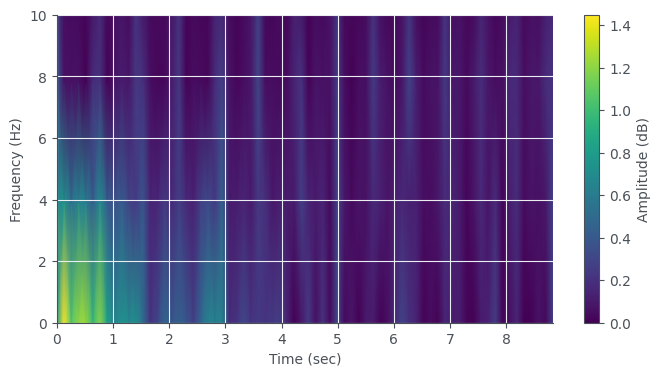

In [ ]:
print("ica_components.shape:", ica_components.shape)
print("ica_components[0].shape (first row):", ica_components[1].shape)

time_limit = 70
for i in range(filtered_fetal_signals.shape[0]):
  # Compute the STFT on the selected component
  f, t, Zxx = stft(filtered_fetal_signals[i, :], fs=fs, nperseg=256)

  # print("Shape of f:", f.shape)
  # print("Shape of t:", t.shape)
  # print("Shape of Zxx:", Zxx.shape)

  # Plot the spectrogram
  plt.figure(figsize=(8, 4))
  plt.pcolormesh(t[:time_limit], f, np.abs(Zxx[:, :time_limit]), shading='gouraud')
  plt.ylabel("Frequency (Hz)")
  plt.xlabel("Time (sec)")
  plt.colorbar(label="Amplitude (dB)")
  plt.ylim([0, 10])
  plt.show()

fetal_rr: [0.528 0.479 0.471 0.48  0.544 0.475 0.888 0.861 0.526 0.466]
maternal_rr: [1.075 0.888 0.861 0.86  0.737 0.899 0.718 0.766 0.827 0.824]
Component 0: Maternal | HR: 71.31 bpm | Dom Freq: 0.29000000000000004 Hz


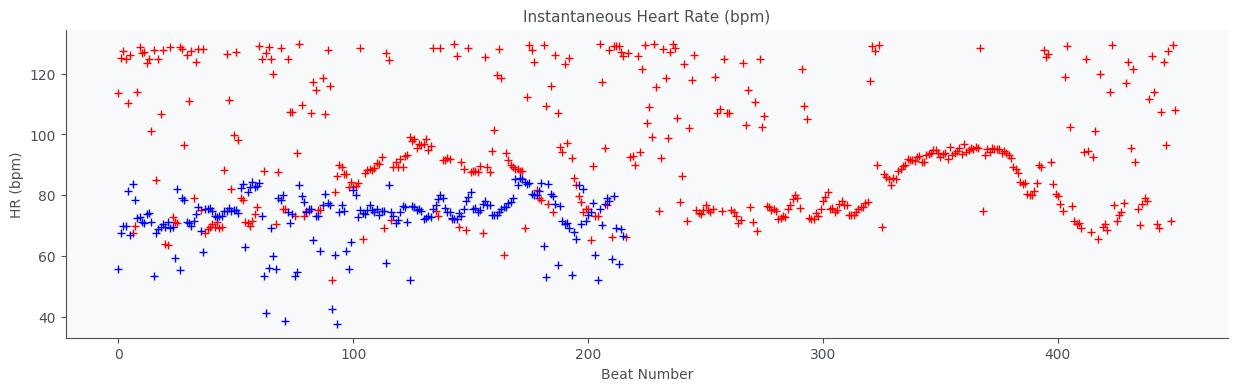

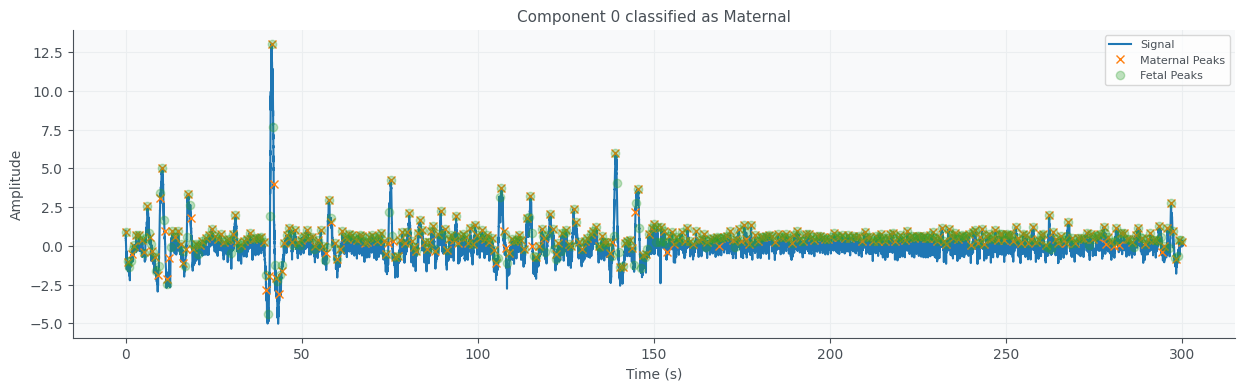

fetal_rr: [0.872 0.87  0.891 0.885 0.864 0.865 0.873 0.893 0.869 0.895]
maternal_rr: [0.872 0.87  0.891 0.885 0.864 0.865 0.873 0.893 0.869 0.895]
Component 1: Maternal | HR: 74.57 bpm | Dom Freq: 1.2566666666666668 Hz


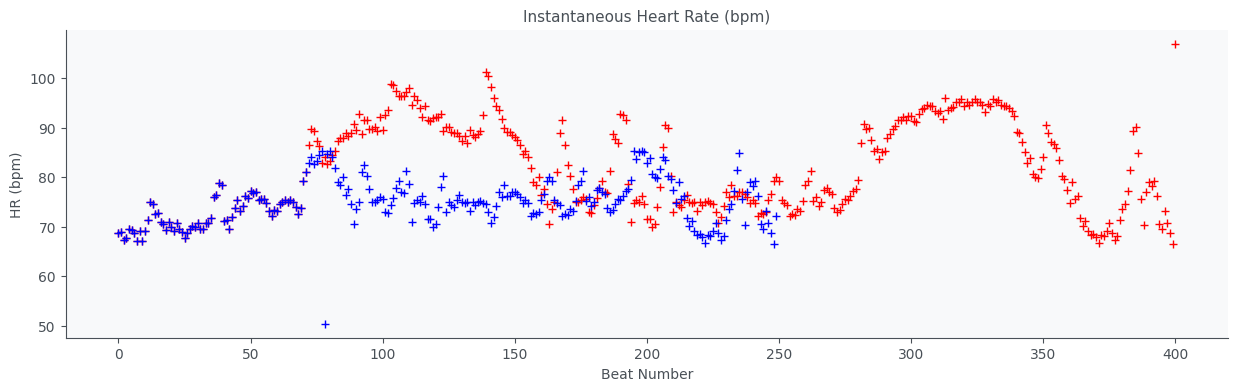

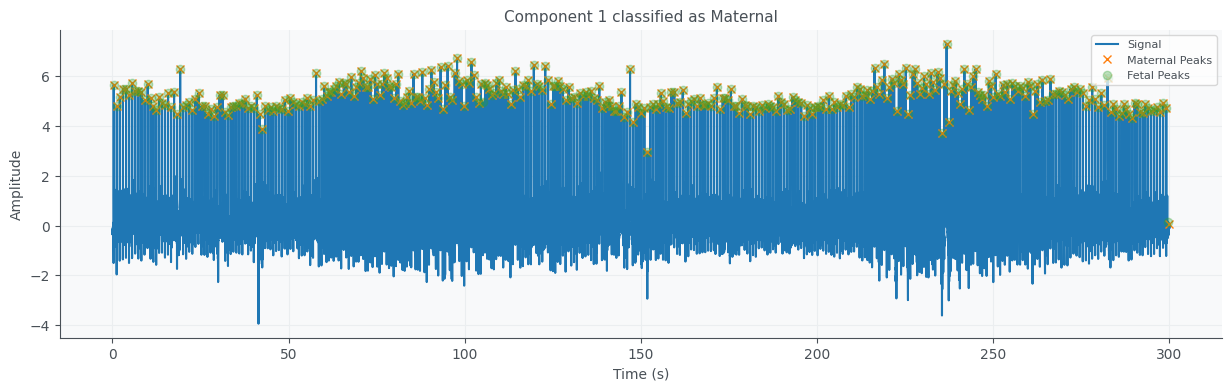

fetal_rr: [0.871 0.87  0.892 0.884 0.864 0.717 0.489 0.533 0.897 0.864]
maternal_rr: [0.871 0.87  0.892 0.884 0.864 0.717 1.022 0.897 0.864 0.896]
Component 2: Maternal | HR: 73.24 bpm | Dom Freq: 0.41000000000000003 Hz


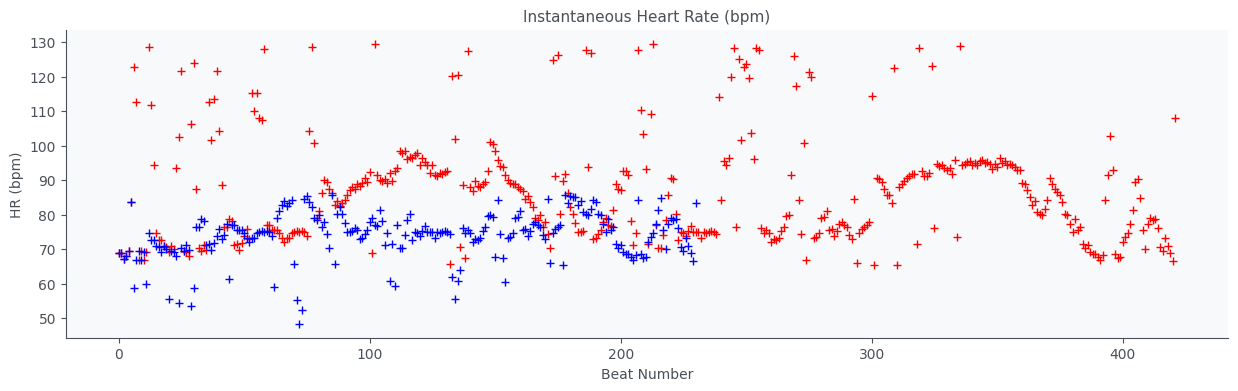

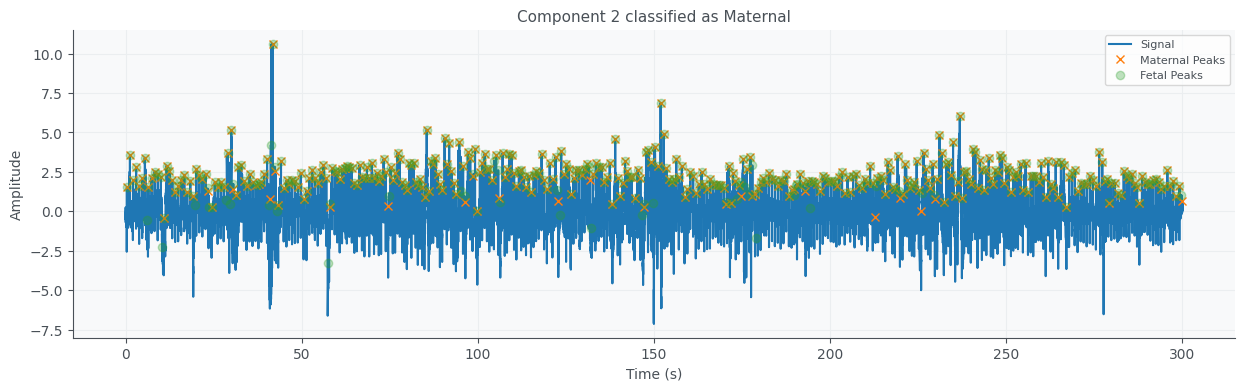

fetal_rr: [0.495 0.492 0.78  0.817 0.505 0.918 0.916 0.486 0.479 0.602]
maternal_rr: [0.987 0.78  0.918 0.802 1.081 0.842 0.926 1.044 0.768 0.791]
Component 3: Maternal | HR: 66.04 bpm | Dom Freq: 0.4066666666666667 Hz


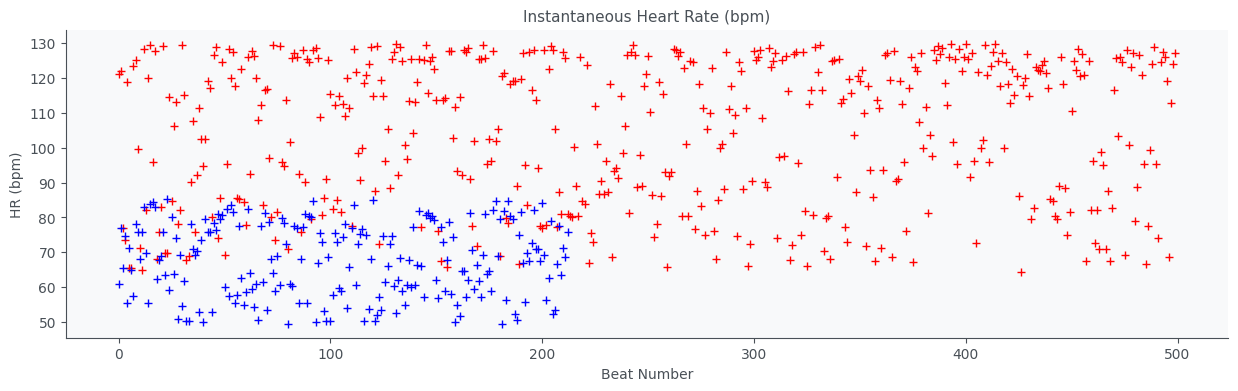

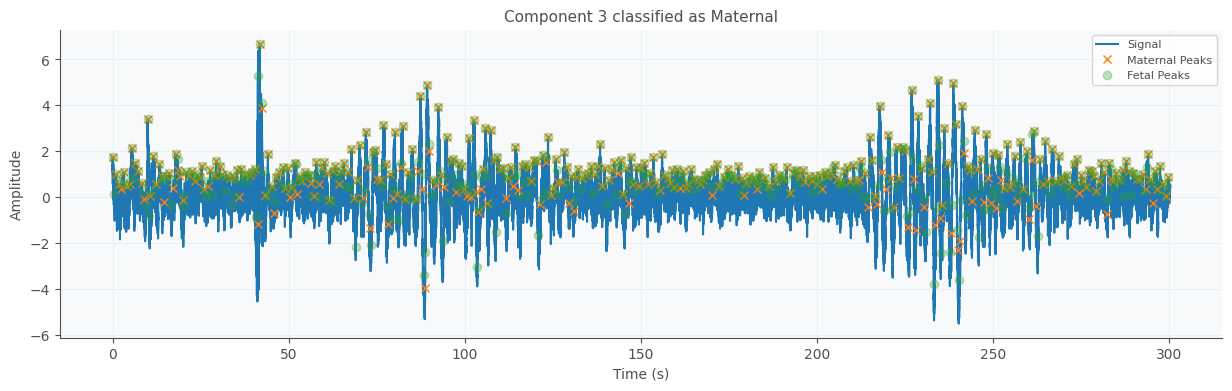

In [ ]:
fetal_or_noise_signal = [1, ica_components.shape[0]]

for i in range(ica_components.shape[0]):
    duration_sec = int(300 * fs)
    rr_size = int(duration_sec / (fs * 10))
    signal = ica_components[i, :duration_sec]

    # Flip if average peak in -signal is stronger
    if np.max(-signal) > np.max(signal):
        signal = -signal

    # Maternal peaks
    maternal_peaks, maternal_props = find_peaks(signal, distance=int(0.6*fs), prominence=0.006)

    if len(maternal_peaks) > 1:
        maternal_rr = np.diff(maternal_peaks) / fs
        maternal_rr = maternal_rr[(maternal_rr > 0.7)]  # filter
        hr_maternal = 60 / np.mean(maternal_rr) if maternal_rr.size > rr_size else np.nan
    else:
        hr_maternal = np.nan

    # Fetal peaks
    fetal_peaks, fetal_props = find_peaks(signal, distance=int(min_rr*fs), prominence=0.006)
    ground_truth_rr = np.mean(rr_intervals) / fs
    if len(fetal_peaks) > 1:
        fetal_rr = np.diff(fetal_peaks) / fs # min_rr
        # fetal_rr = fetal_rr[(fetal_rr > ground_truth_rr-0.05) & (fetal_rr < ground_truth_rr+0.05)]  # filter
        hr_fetal = 60 / np.mean(fetal_rr) if maternal_rr.size > rr_size else np.nan
    else:
        hr_fetal = np.nan

    print(f"fetal_rr: {fetal_rr[:10]}")
    print(f"maternal_rr: {maternal_rr[:10]}")

    density_fetal = len(fetal_peaks) / duration_sec
    density_maternal = len(maternal_peaks) / duration_sec

    consistency_fetal = np.std(fetal_rr)
    consistency_maternal = np.std(maternal_rr)

    # Frequency domain analysis
    yf = np.abs(np.fft.rfft(signal))
    xf = np.fft.rfftfreq(signal.shape[0], 1 / fs)

    # Limit to cardiac-relevant band (0.5–5 Hz)
    mask = (xf > 0.1) & (xf < 5)
    dominant_freq = xf[mask][np.argmax(yf[mask])]

    fetal_ihr_hz = 1 / fetal_rr
    fetal_ihr_bpm = 60 / fetal_rr
    maternal_ihr_hz = 1 / maternal_rr
    maternal_ihr_bpm = 60 / maternal_rr

    if (np.abs(np.mean(fetal_ihr_bpm) - np.mean(maternal_ihr_bpm)) > 10) & (fetal_rr[0] > 20):
        label, hr = "Fetal or Noise", hr_fetal
        fetal_or_noise_signal.append(signal)
    else:
        label, hr = "Maternal", hr_maternal
    print(f"Component {i}: {label} | HR: {hr:.2f} bpm | Dom Freq: {dominant_freq} Hz")

    plt.figure(figsize=(15, 4))
    plt.plot(fetal_ihr_bpm, "r+", label="Fetal IHRs")
    plt.plot(maternal_ihr_bpm, "b+", label="Maternal IHRs")
    plt.title("Instantaneous Heart Rate (bpm)")
    plt.xlabel("Beat Number")
    plt.ylabel("HR (bpm)")
    plt.grid()
    plt.show()


    # Main plot:
    plt.figure(figsize=(15, 4))
    plt.plot(time[:duration_sec], signal, label="Signal")
    plt.plot(time[maternal_peaks], signal[maternal_peaks], "x", label="Maternal Peaks")
    plt.plot(time[fetal_peaks], signal[fetal_peaks], "o", label="Fetal Peaks", alpha=0.3)
    plt.title(f"Component {i} classified as {label}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

<Figure size 1200x800 with 0 Axes>

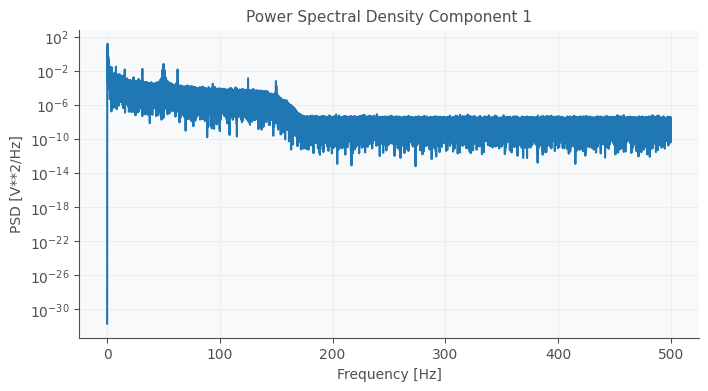

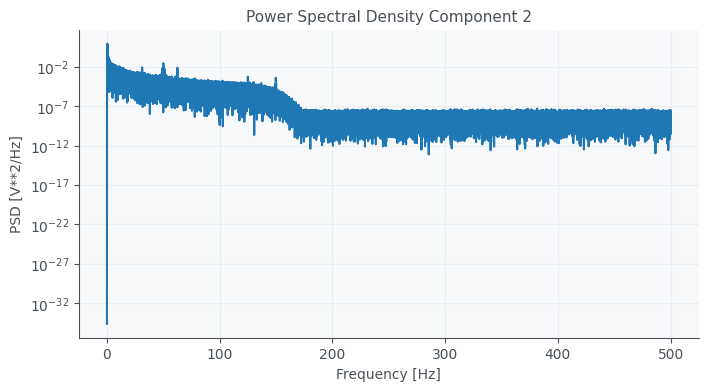

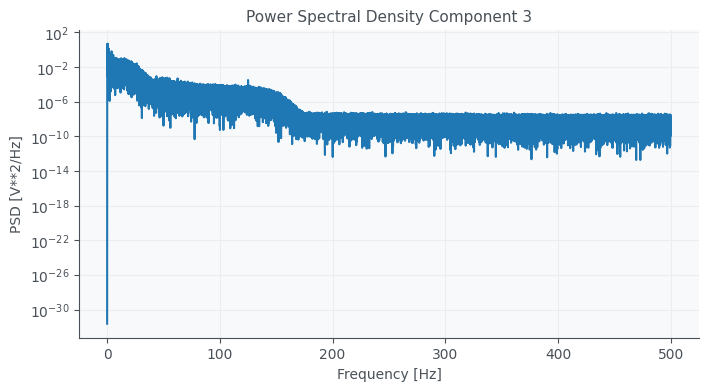

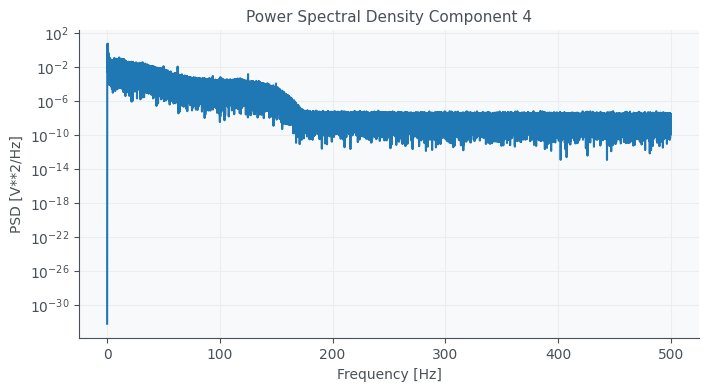

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(ica_components.shape[0]):
    signal_i = ica_components[i, :]

    X = np.fft.rfft(signal_i)
    freq = np.fft.rfftfreq(ica_components.shape[1], 1/fs)

    # Υπολογισμός του PSD με κατάλληλη κανονικοποίηση
    PSD = (1/(fs * ica_components.shape[1])) * np.abs(X)**2
    PSD[1:-1] = 2 * PSD[1:-1]

    # Εμφάνιση του PSD για το συγκεκριμένο component
    plt.figure(figsize=(8, 4))
    plt.semilogy(freq, PSD)
    plt.title(f'Power Spectral Density Component {i+1}')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    # plt.xlim(0, 10)  # Εστίαση στα Hz, περιοχή ενδιαφέροντος για ECG
    # plt.ylim(1e-6, 1)
    plt.show()


<Figure size 1200x800 with 0 Axes>

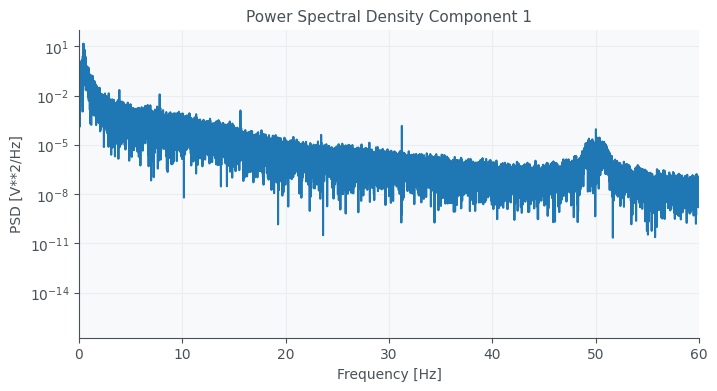

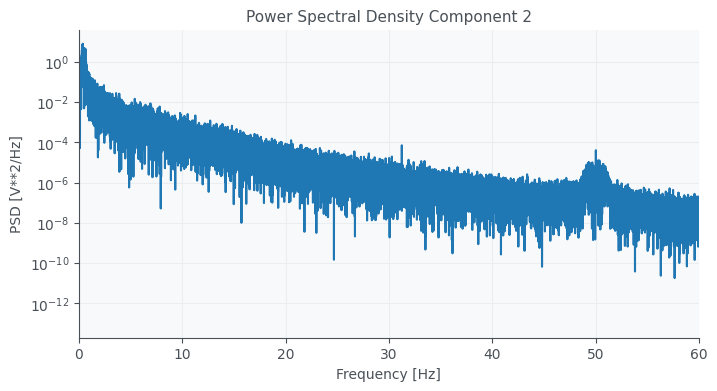

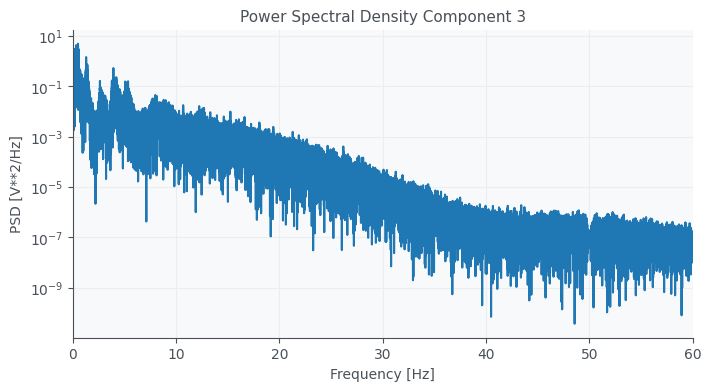

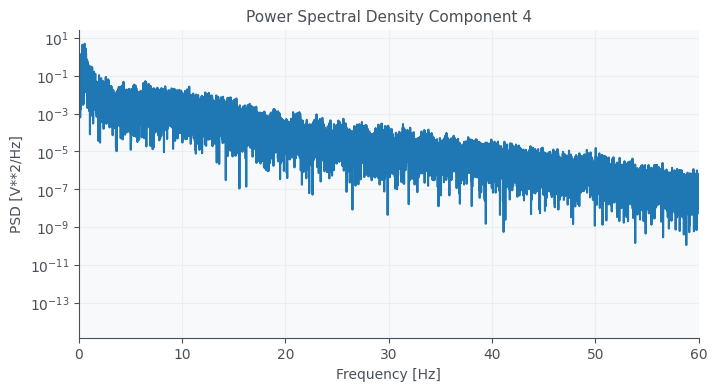

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(filtered_fetal_signals.shape[0]):
    signal_i = filtered_fetal_signals[i, :]

    X = np.fft.rfft(signal_i)
    freq = np.fft.rfftfreq(filtered_fetal_signals.shape[1], 1/fs)

    # Υπολογισμός του PSD με κατάλληλη κανονικοποίηση
    PSD = (1/(fs * filtered_fetal_signals.shape[1])) * np.abs(X)**2
    PSD[1:-1] = 2 * PSD[1:-1]

    # Εμφάνιση του PSD για το συγκεκριμένο component
    plt.figure(figsize=(8, 4))
    plt.semilogy(freq, PSD)
    plt.title(f'Power Spectral Density Component {i+1}')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.xlim(0, 60)  # Εστίαση στα Hz, περιοχή ενδιαφέροντος για ECG
    # plt.ylim(1e-6, 1)
    plt.show()
